# TP 1 - Différences finies

## Objectif du TP

L’objectif de ce TP est de résoudre l’équation d’advection 1D à l’aide de plusieurs schémas différences finies. On rappelle que cette équation d’advection 1D peut s’écrire :

$$\frac{\partial u}{\partial t}+a \frac{\partial u}{\partial x}=0$$

L’implémentation des différents schémas se fera dans un script Python (ou, éventuellement, Julia).

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Matplotlib formating
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.constrained_layout.use'] = True

## 1 - Construction et visualisation du maillage et de la condition initiale

On considère un domaine 1D de longueur L, discrétisé en $m$ points. Les deux conditions initiales envisagées sont
les suivantes :

**CI1** : $u^{0}=\sin \left(\frac{2 \beta x_{i}}{L}\right)$, où $\beta$ est le numéro du mode considéré.

**CI2** : $u^{0}=0 \text { si } x<x_{0}, u^{0}=1 \text { sinon. }$

Pour commencer, on choisira les valeurs numériques suivantes : $L = 1$, $m = 100$.

In [3]:
# Configuration par defaut
L = 1.0  # Longeur L, 1.0 par défaut
m = 100  # Nombre de point de discrétisation m, par défaut 100
X = np.linspace(start=0, stop=L, num=m)
# X = np.array([i*(L/(m-1)) for i in range(m)])
delta_x = L/(m-1)

Construire les tableaux x, contenant les abscisses des points du maillage, et $u_0$, la solution initiale, puis les
visualiser avec Matplotlib.

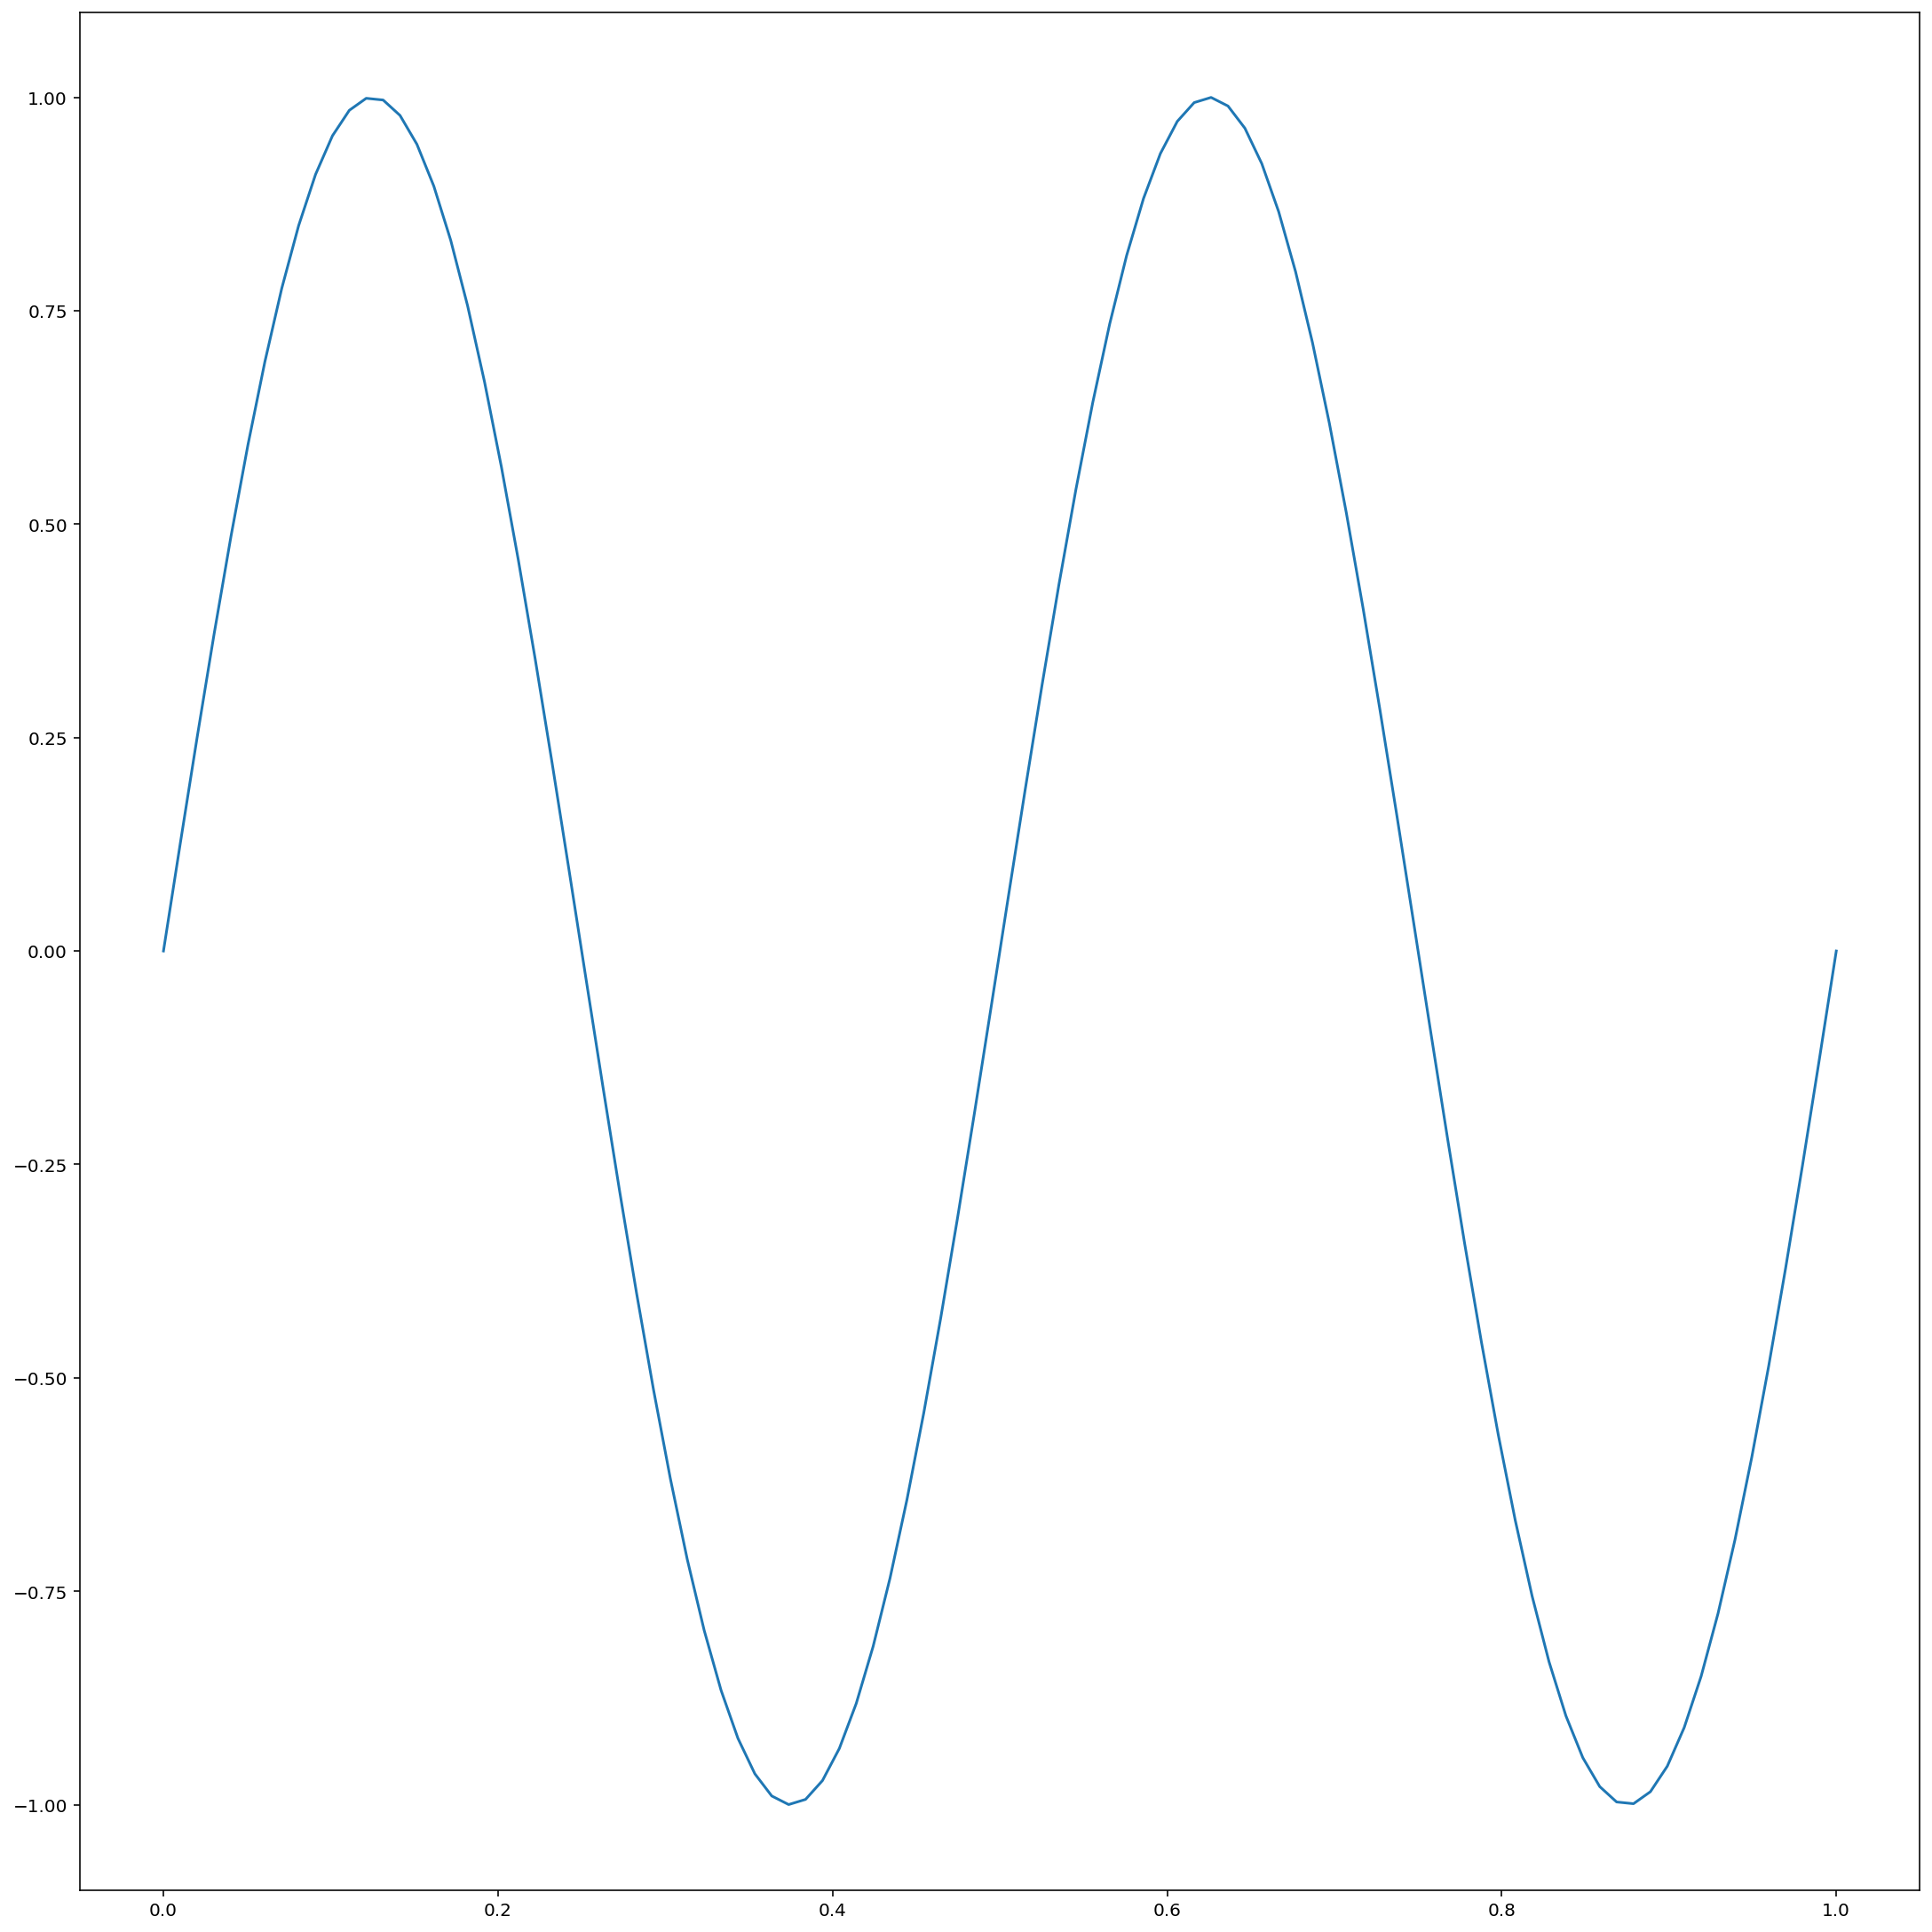

In [4]:
def CI1(X:np.ndarray, beta:float=2) -> np.ndarray:
    u_zero = np.sin((2*beta*X*np.pi)/L)
    return u_zero

u_zero = CI1(X, beta=2)
plt.plot(X, u_zero)
plt.show()

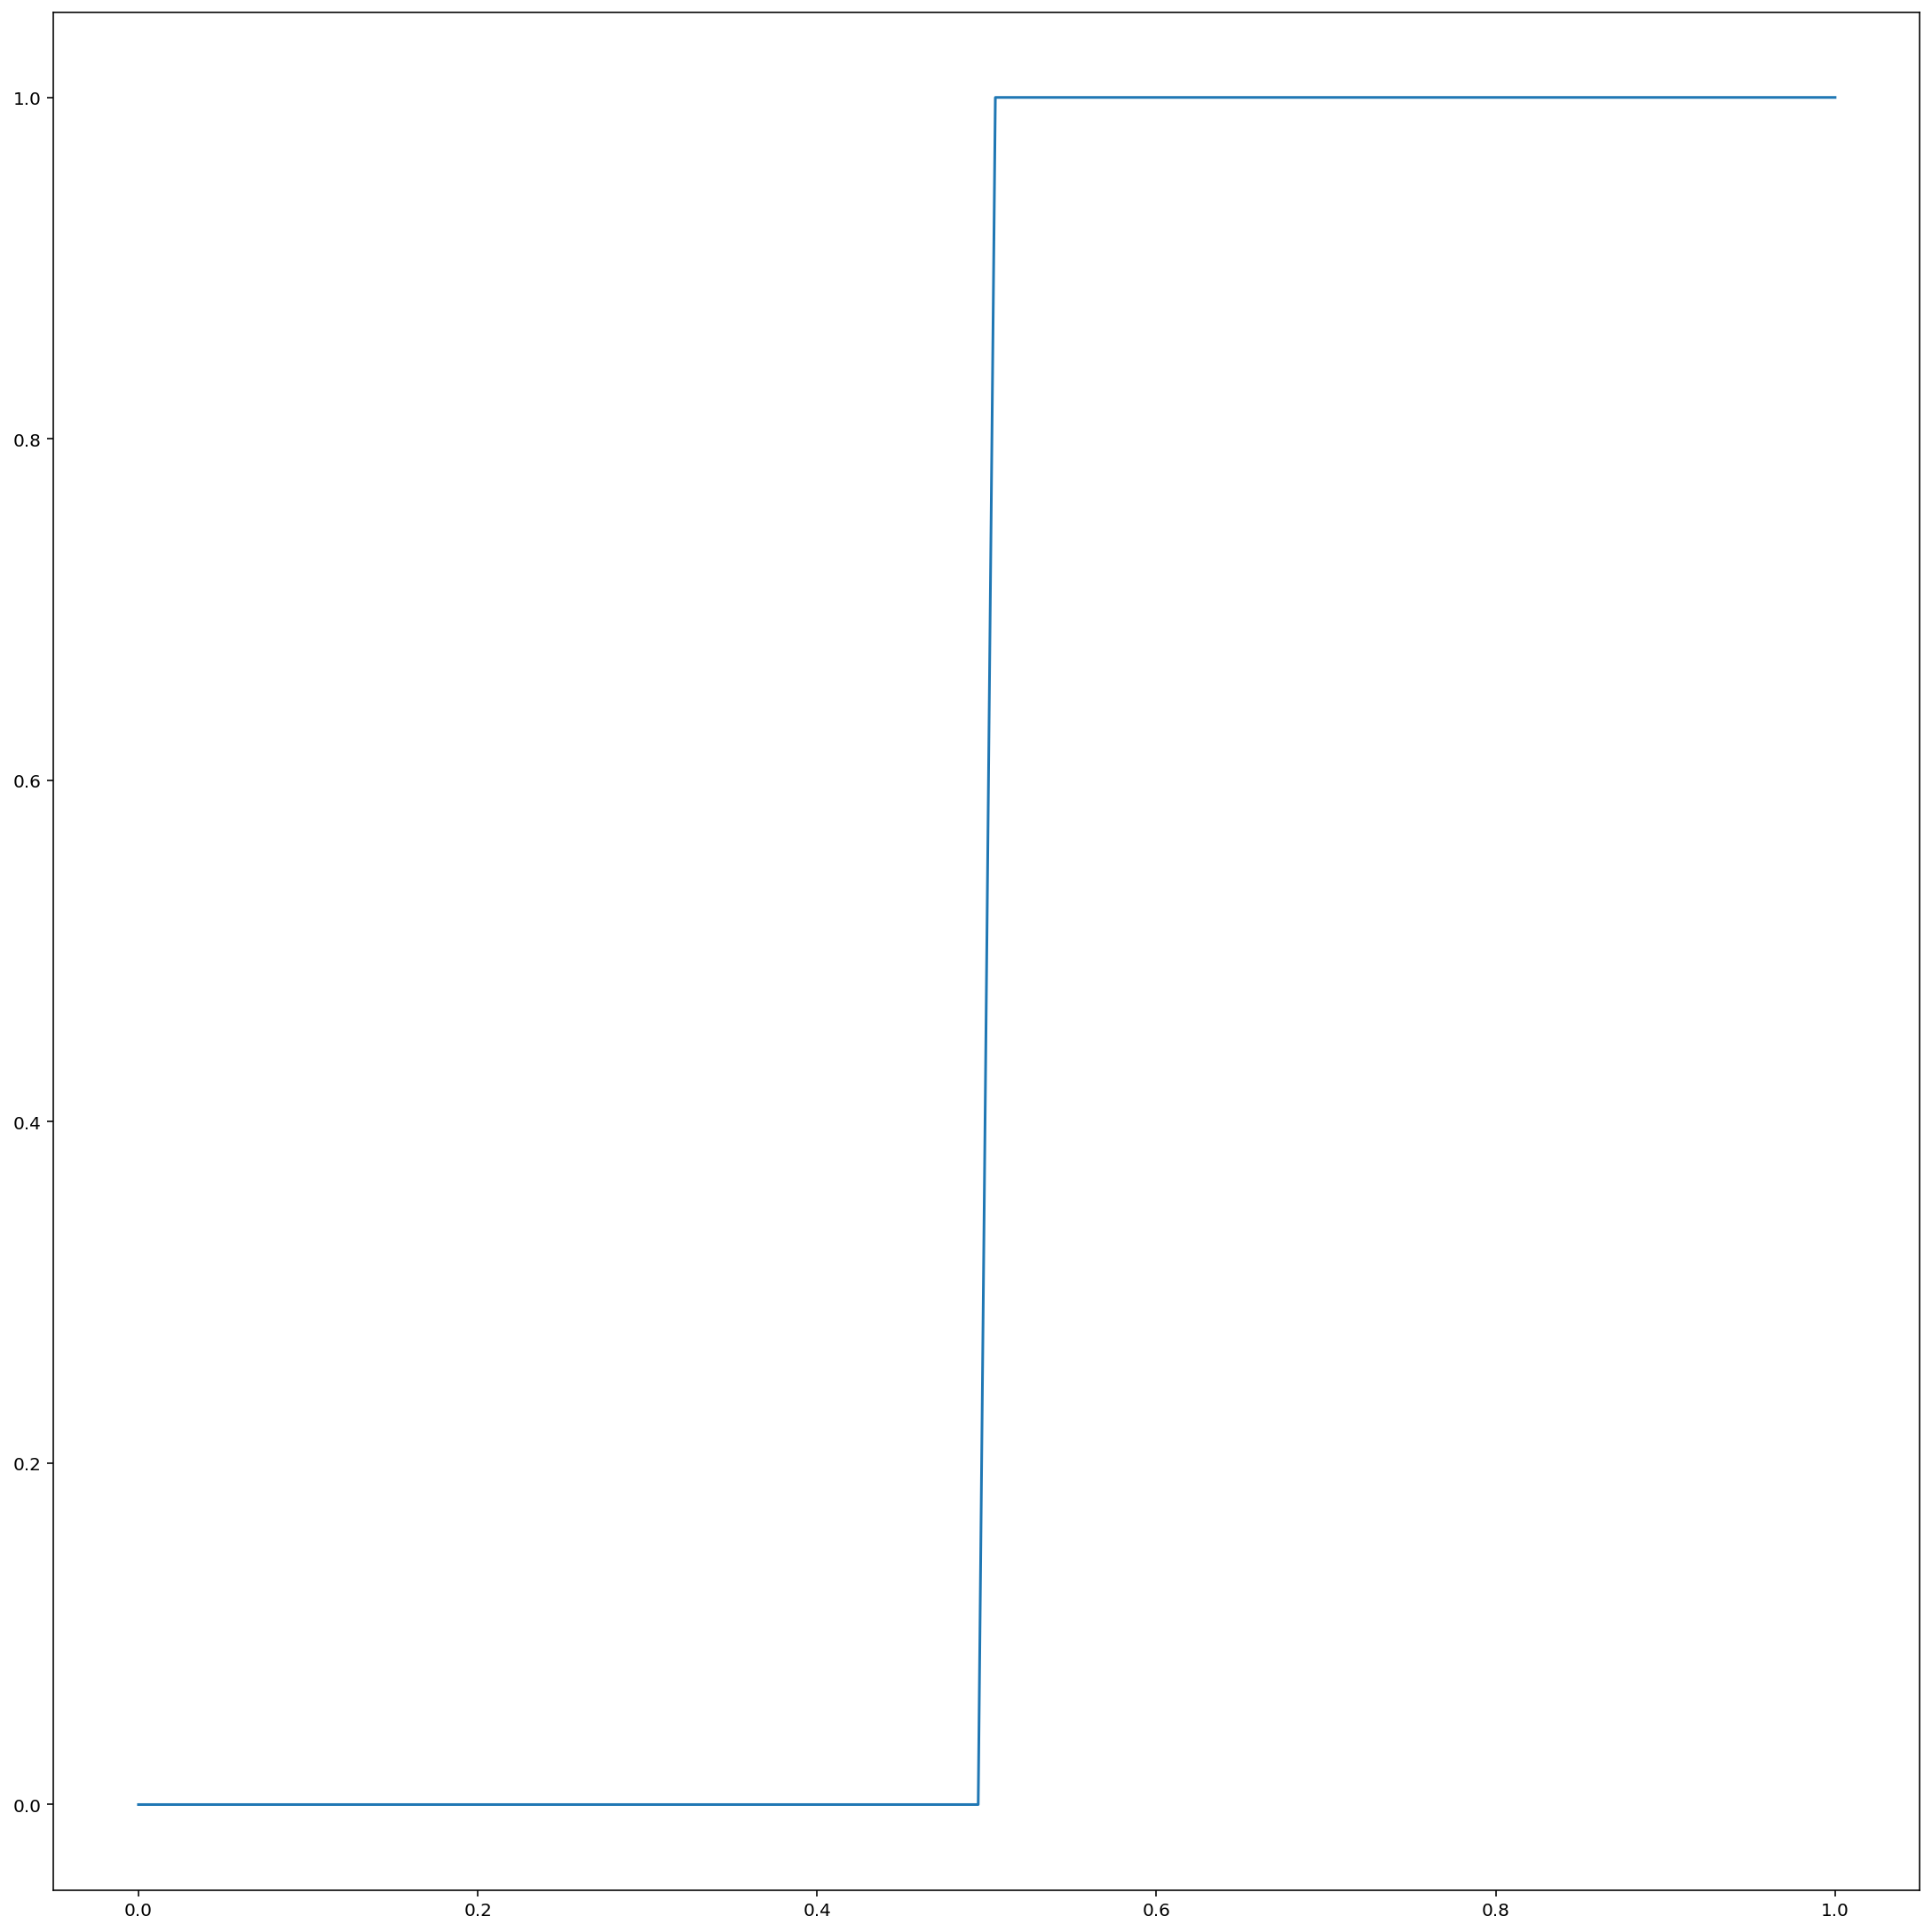

In [5]:
def CI2(X:np.ndarray, x0:float=0.5) -> np.ndarray:
    u_zero = np.array([(0 if xi<x0 else 1) for xi in X])
    return u_zero

u_zero = CI2(X, x0=0.5)
plt.plot(X, u_zero)
plt.show()


## 2 - Étude du comportement de schémas différences finies

### 2.1 Paramètres physiques et numériques

Par la suite, on considèrera le problème physique suivant (sauf indication contraire dans l’énoncé) :
- Vitesse de convection $a = 1$
- Conditions limites périodiques en espace
- Solution observée au terme d’un temps $T$ lui permettant de revenir à sa position initiale.

On rappelle que le nombre de Courant, noté $\mathcal{C}$, est défini comme :

$$\mathcal{C}=\frac{a \Delta t}{\Delta x}$$

Ce nombre sera pris égal à $0.5$ par défaut.

In [6]:
C = 0.5 # nombre de Courant, 0.5 par défaut
a = 1 # Vitesse de convection, 1 par défaut
delta_t = C*delta_x/np.abs(a)

### 2.2 Méthodologie

In [7]:
## Fonction pour avoir u_i de façon cyclique, l'usage de np.roll est mieux
# def get_u_i(u:np.ndarray, i:int) -> float:
#     I = u.shape[0]
#     if 0 <= i < I:
#         return u[i]
#     else:
#         return get_u_i(u, i%I)

## Rappel du schéma semi-discret **FOU** (schéma décentré amont, $a+$):

$$\frac{d u}{d t}=-\frac{a}{\Delta x}\left(u_{i}-u_{i-1}\right)$$

En intégration temporelle d'`Euler Explicite`
$$u_{i}^{n+1}=u_{i}^{n}-\mathcal{C}\left(u_{i}^{n}-u_{i-1}^{n}\right)$$

In [8]:
def FOU_EE(ui, C=0.5):
    ui_plus = ui - C*(ui - np.roll(ui, shift=+1))
    return ui_plus


## Rappel du schéma semi-discret **FOF** :

$$\frac{d u}{d t}=-\frac{a}{\Delta x}\left(u_{i+1}-u_{i}\right)$$

En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\mathcal{C}\left(u_{i+1}^{n}-u_{i}^{n}\right)$$

In [9]:
def FOF_EE(ui, C=0.5):
    ui_plus = ui - C*(np.roll(ui, shift=-1) - ui)
    return ui_plus


## Rappel du schéma semi-discret **SOC** :

$$\frac{d u}{d t}=-\frac{1}{2}\frac{a}{\Delta x}\left(u_{i+1}-u_{i-1}\right)$$

En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\frac{\mathcal{C}}{2}\left(u_{i+1}^{n}-u_{i-1}^{n}\right)$$

In [16]:
def SOC_EE(ui, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui, shift=-1) - np.roll(ui, shift=+1))
    return ui_plus


## Rappel du schéma semi-discret **Lax_Wendroff** :

$$\frac{d u}{d t}=-\frac{1}{2}\frac{a}{\Delta x}\left(u_{i}-u_{i-1}\right) + \frac{1}{2}\left(\frac{a}{\Delta x}\right)^2\left(u_{i+1}-2u_{i} + u_{i-1}\right)$$


En intégration temporelle d'`Euler Explicite`

$$u_{i}^{n+1}=u_{i}^{n}-\frac{\mathcal{C}}{2}\left(u_{i+1}^{n}-u_{i-1}^{n}\right)+\frac{\mathcal{C}^{2}}{2}\left(u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}\right)$$

In [17]:
def Lax_Wendroff_EE(ui, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui, shift=-1) - np.roll(ui, shift=+1)) + \
        0.5*C**2*(np.roll(ui, shift=-1) - 2*ui + np.roll(ui, shift=+1))
    return ui_plus


Pour chaque schéma numérique implémenté, on répondra aux questions suivantes :
- Visualiser les solutions obtenues en partant de la condition initiale CI1, en utilisant successivement des valeurs
de $n$ égales à $2$, $4$, $8$ et $16$ et noter vos observations.
- Pour la condition initiale correspondant à $n = 1$, réaliser des simulations avec les nombres $\mathcal{C}$ égaux à $0.1$, $0.2$, $0.4$, $0.8$, $1$, $1.5$ et noter vos observations.
- Utiliser maintenant la condition initiale CI2. Sortir la solution à $\mathcal{C} = 1$ aux instants suivants : $T/4$, $T/2$, $T/2$ et enfin $T$.
- Refaire l’étude sur l’influence du nombre $\mathcal{C}$ avec la condition initiale CI2.
- Toujours avec CI2 et $\mathcal{C} = 0.1$, étudiez l’influence de la discrétisation spatiale sur le résultat en prenant successivement un nombre de points m égal à $4$, $10$, $20$, $50$, $100$ et $200$.
- Que se passe-t-il si l’on change le signe de a ?

In [53]:
def get_X(L=1, m=100):
    X = np.linspace(start=0, stop=L, num=m)
    return X
    
def plot_sol(schema=FOU_EE, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1, 
            trace=False, save=False, show=True, ax=plt):
    X = get_X(L, m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)
        
    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t)
    tMax = int(tMax/P)

    # t = t_0
    ut = u0
    ax.plot(X, ut)

    # t = t_i
    for t in range(tMax):
        ut = schema(ut, C)
        if trace:
            ax.plot(X, ut, c=(t/tMax, 0., 0.), alpha=0.01)

    # t = t_max
    ut = schema(ut, C)
    ax.plot(X, ut)
    if ax==plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()

Visualiser les solutions obtenues en partant de la condition initiale CI1, en utilisant successivement des valeurs
de $n$ égales à $2$, $4$, $8$ et $16$ et noter vos observations.

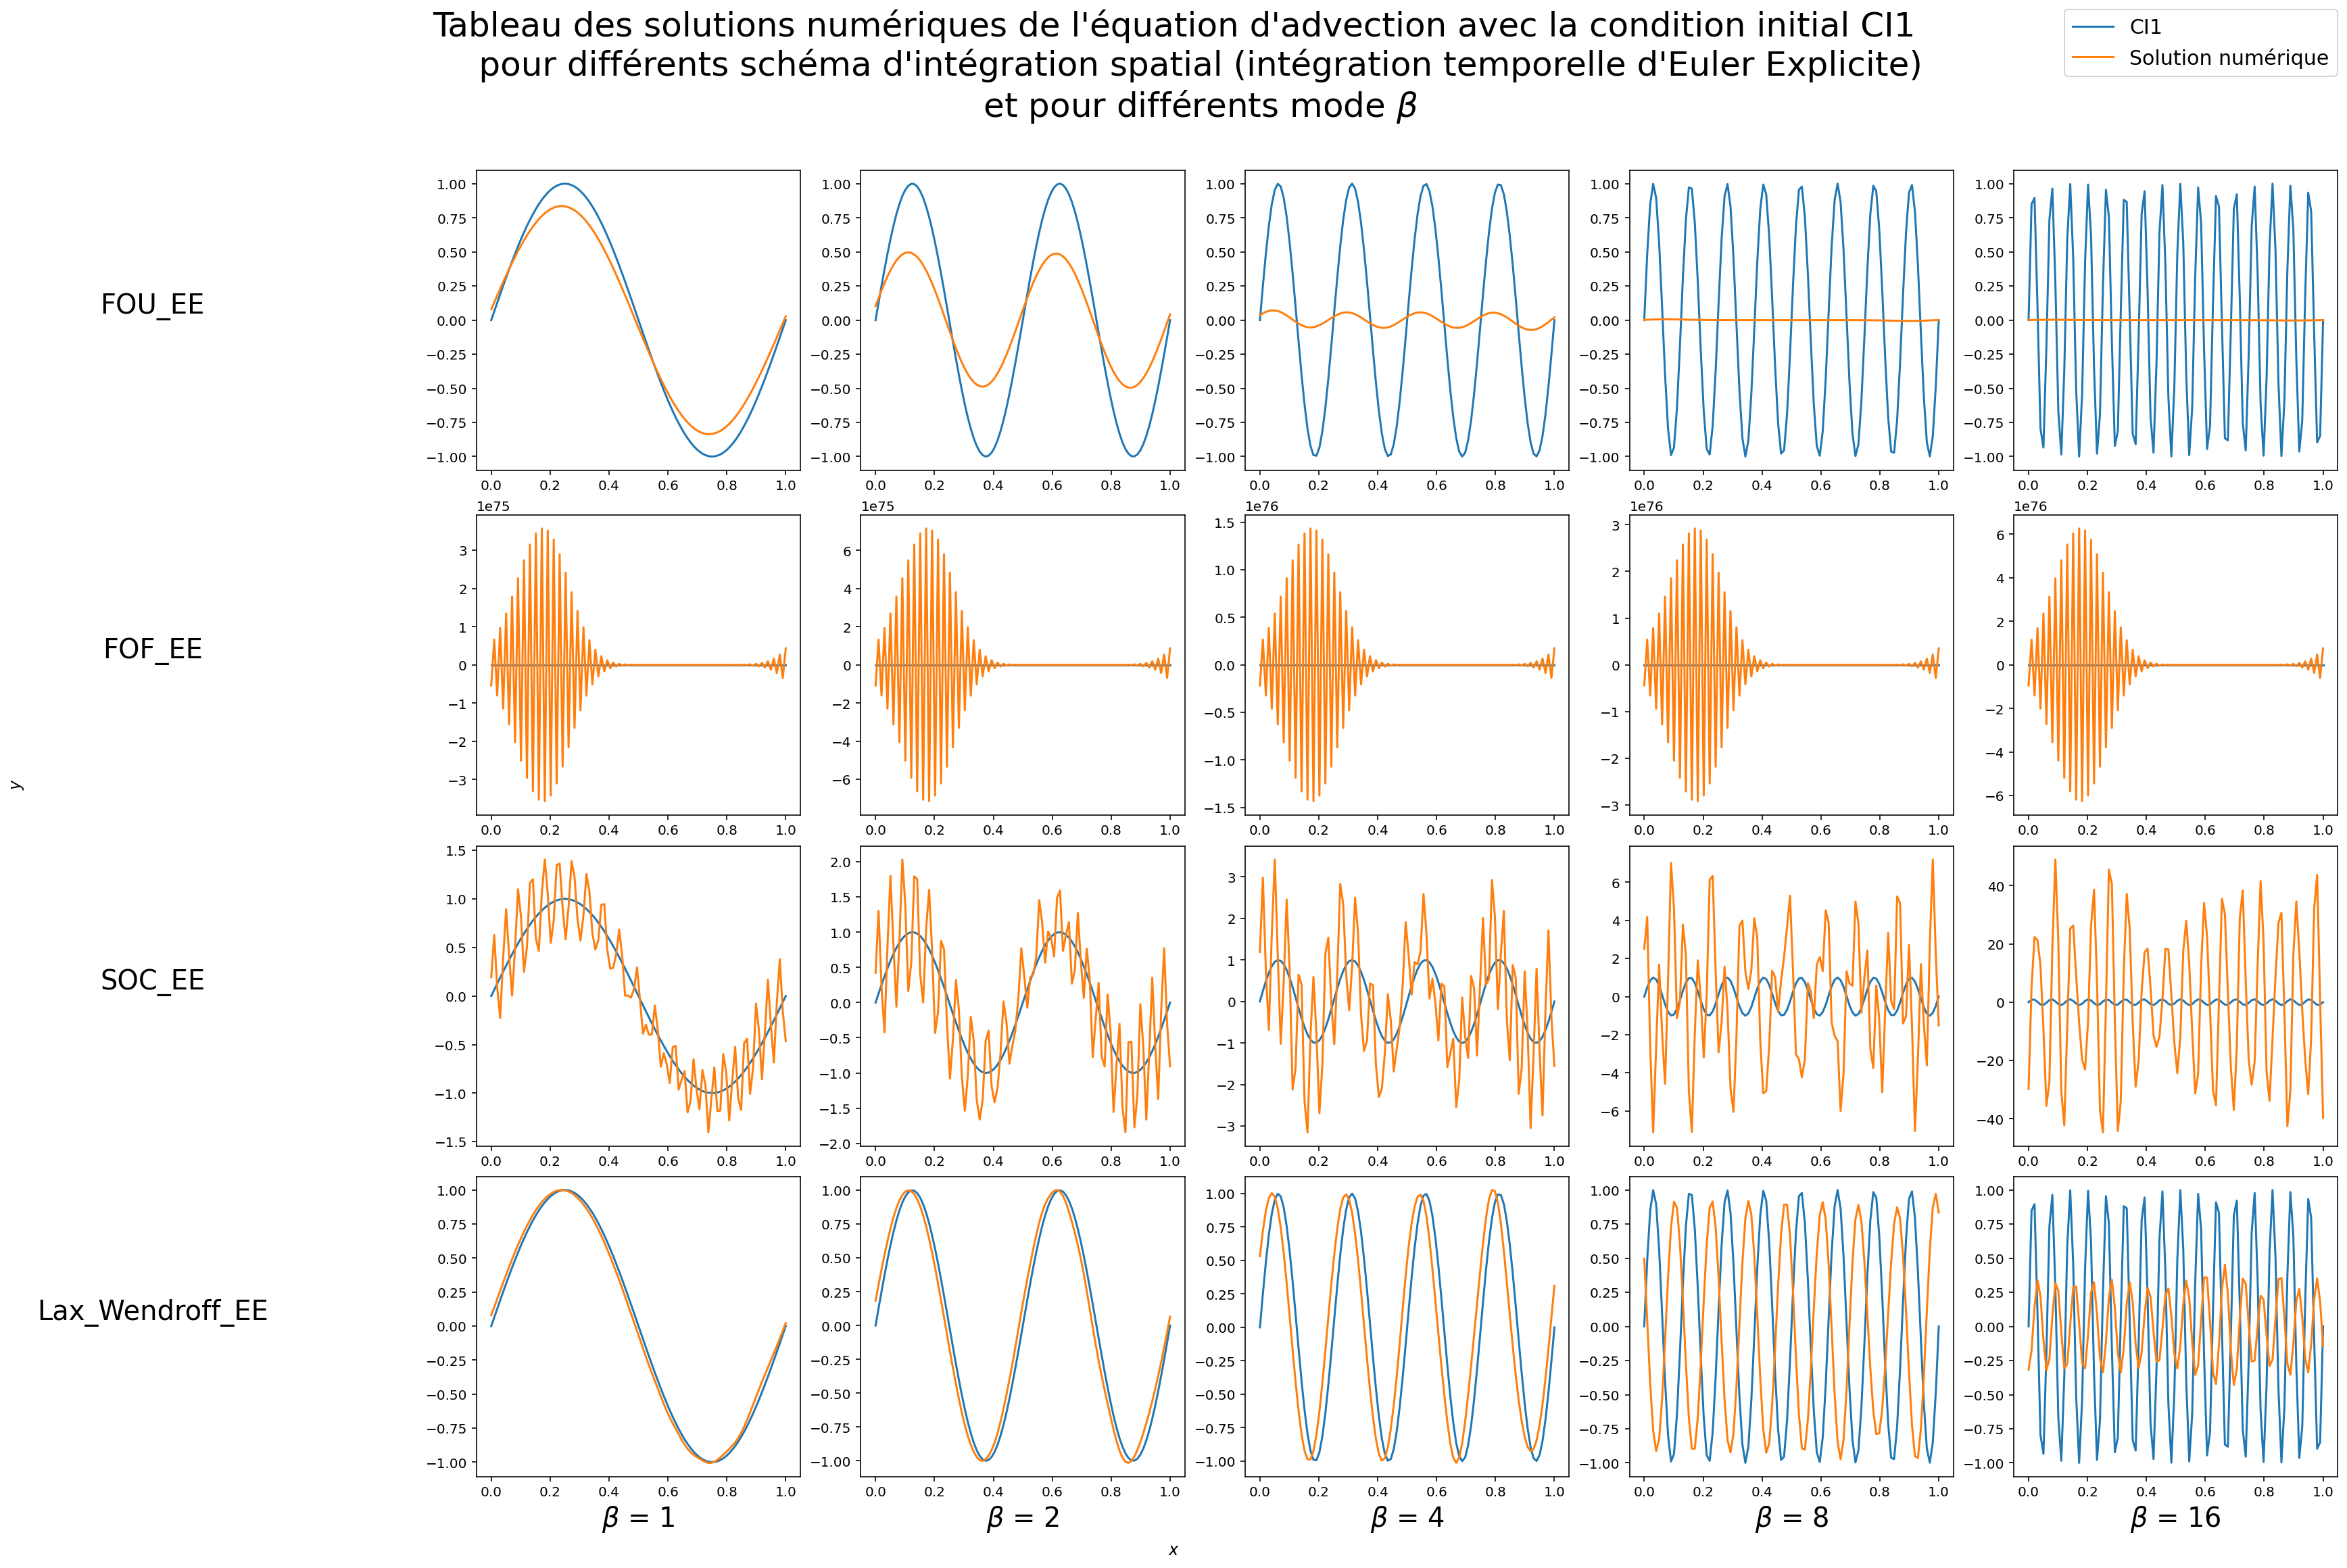

In [56]:
beta_list = [1, 2, 4, 8, 16]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(beta_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différents mode $\\beta$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")

for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, beta in enumerate(beta_list):
        axs[-1, j].set_xlabel(f"$\\beta$ = {beta}", rotation=0,
                             size=20)
        plot_sol(schema=schema, function_name='CI1', L=1,
                 m=100, C=0.1, a=1.0, beta=beta, x0=0.5, P=1, ax=axs[i, j], trace=False)
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


- Pour la condition initiale correspondant à $n = 1$, réaliser des simulations avec les nombres $\mathcal{C}$ égaux à $0.1$, $0.2$, $0.4$, $0.8$, $1$, $1.5$ et noter vos observations.

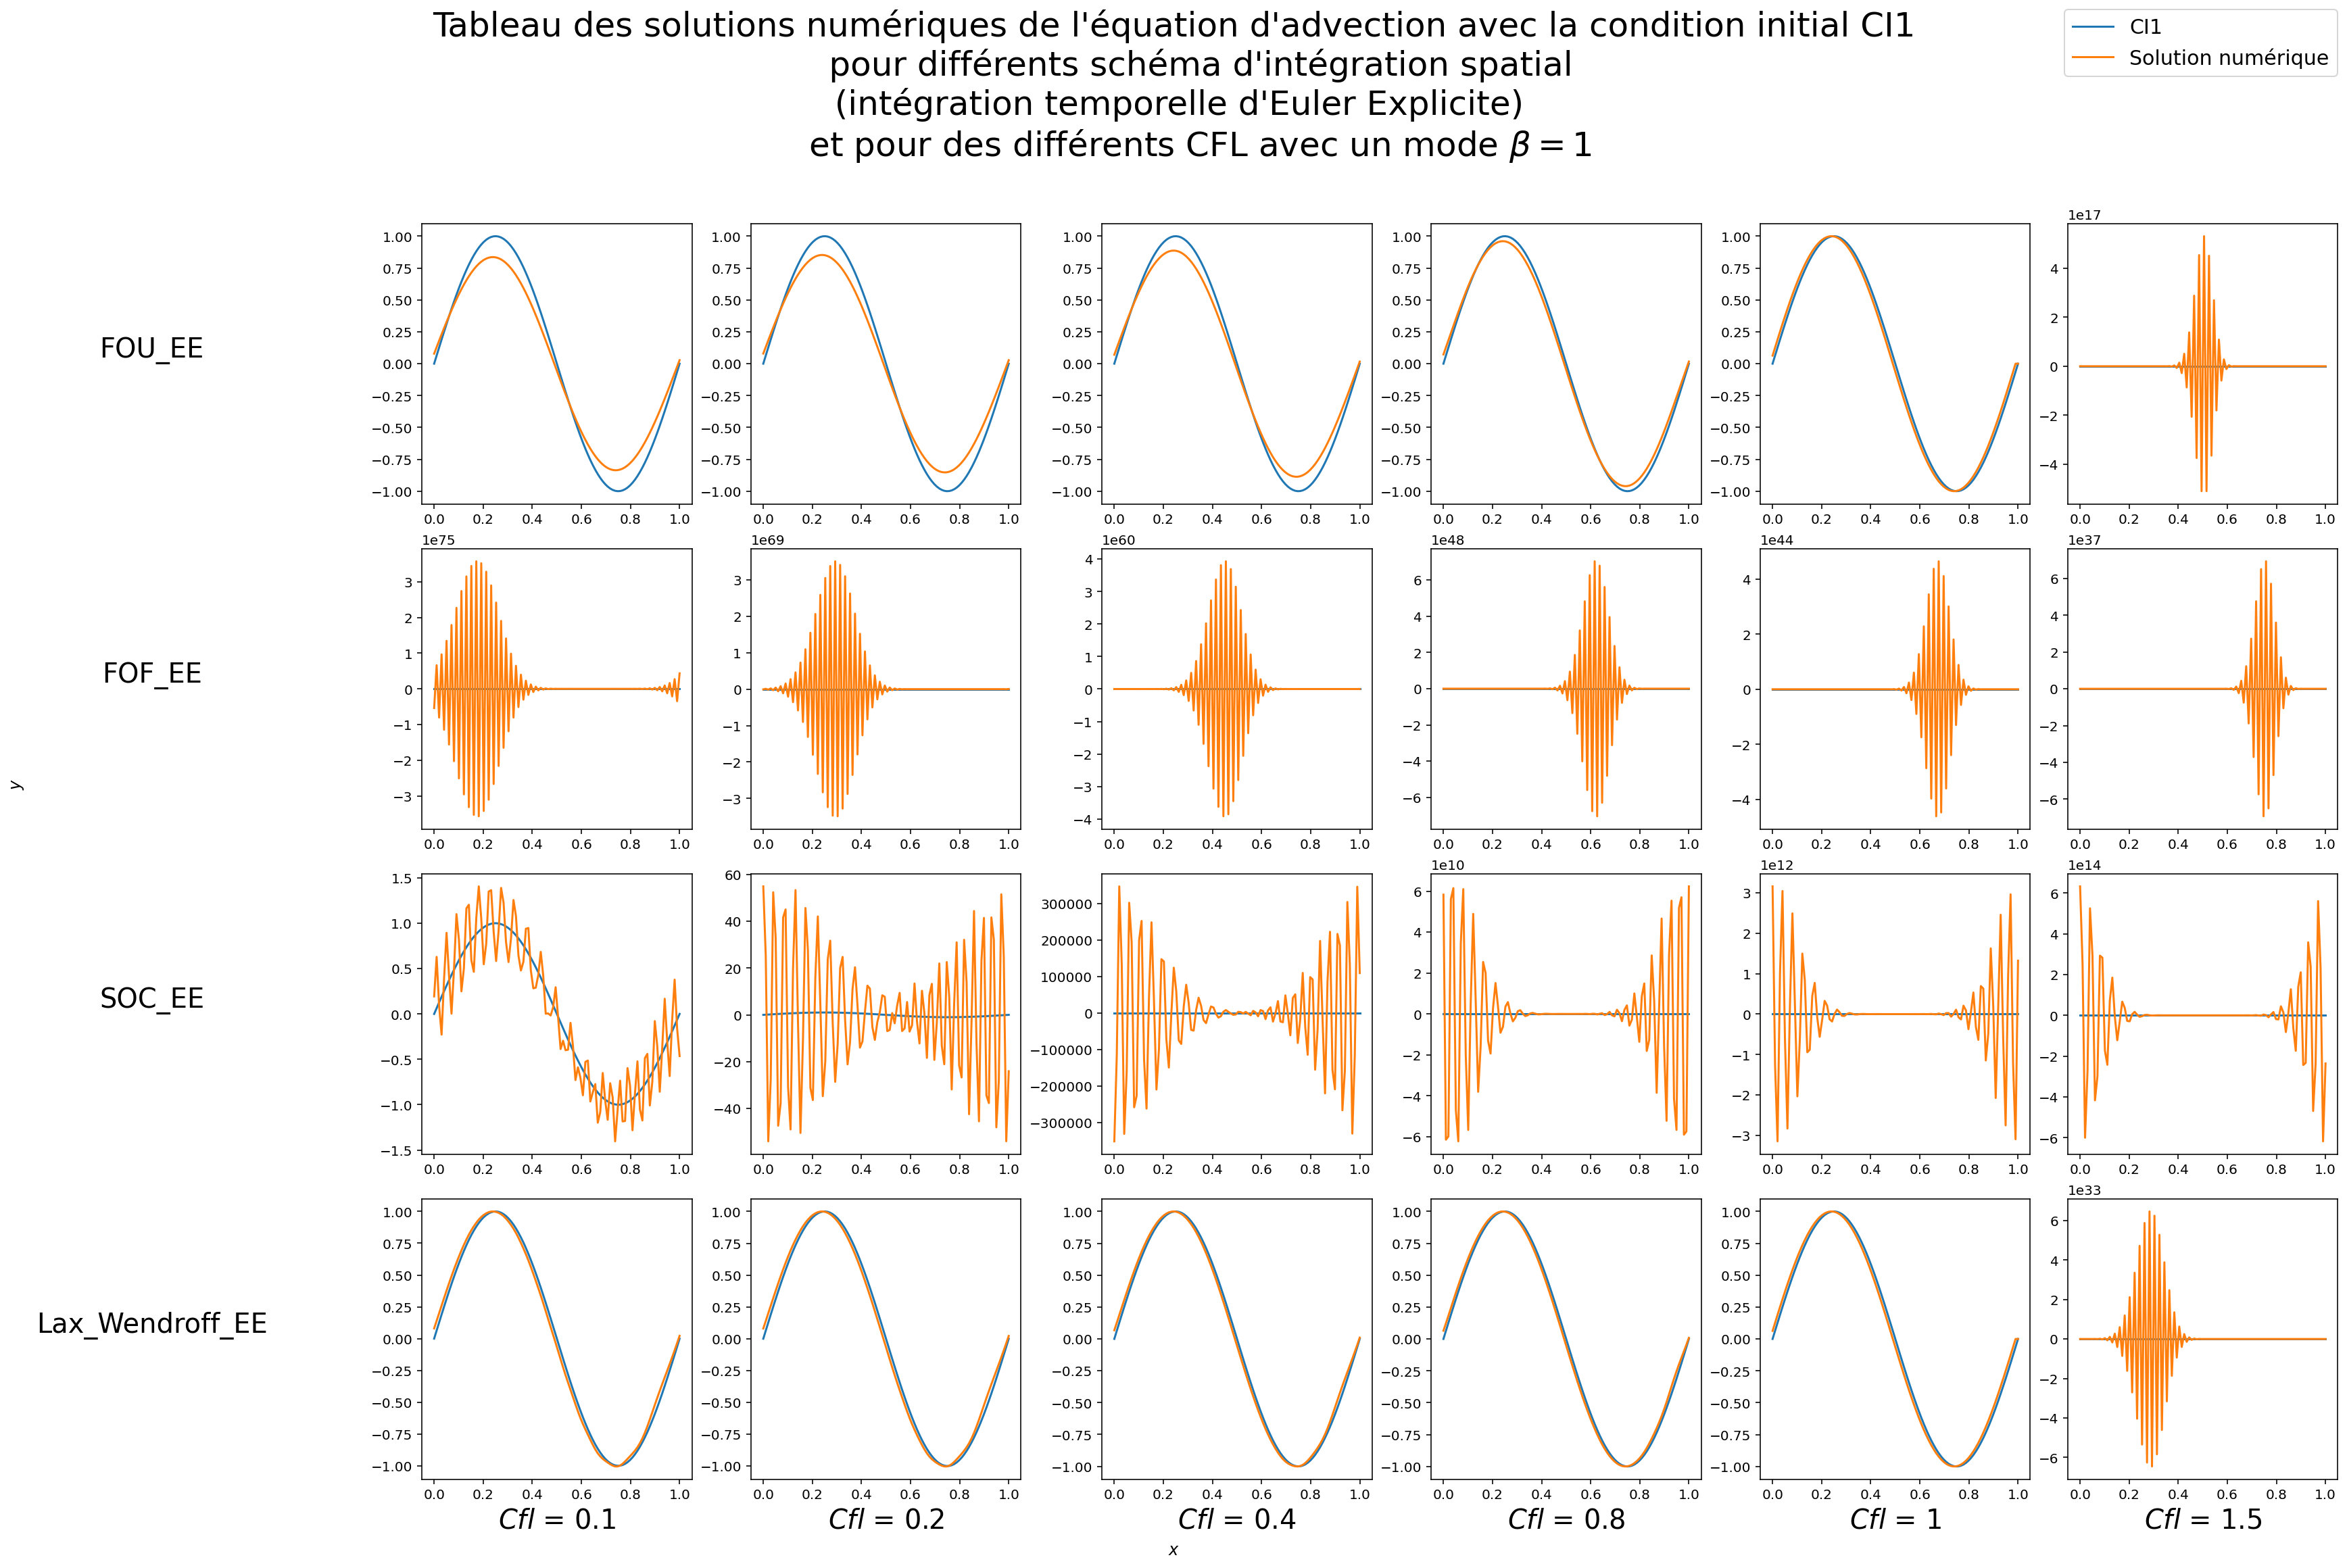

In [39]:
cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI1', L=1,
                 m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


- Utiliser maintenant la condition initiale CI2. Sortir la solution à $C = 1$ aux instants suivants : $T/4$, $T/2$, $T/2$ et enfin $T$.

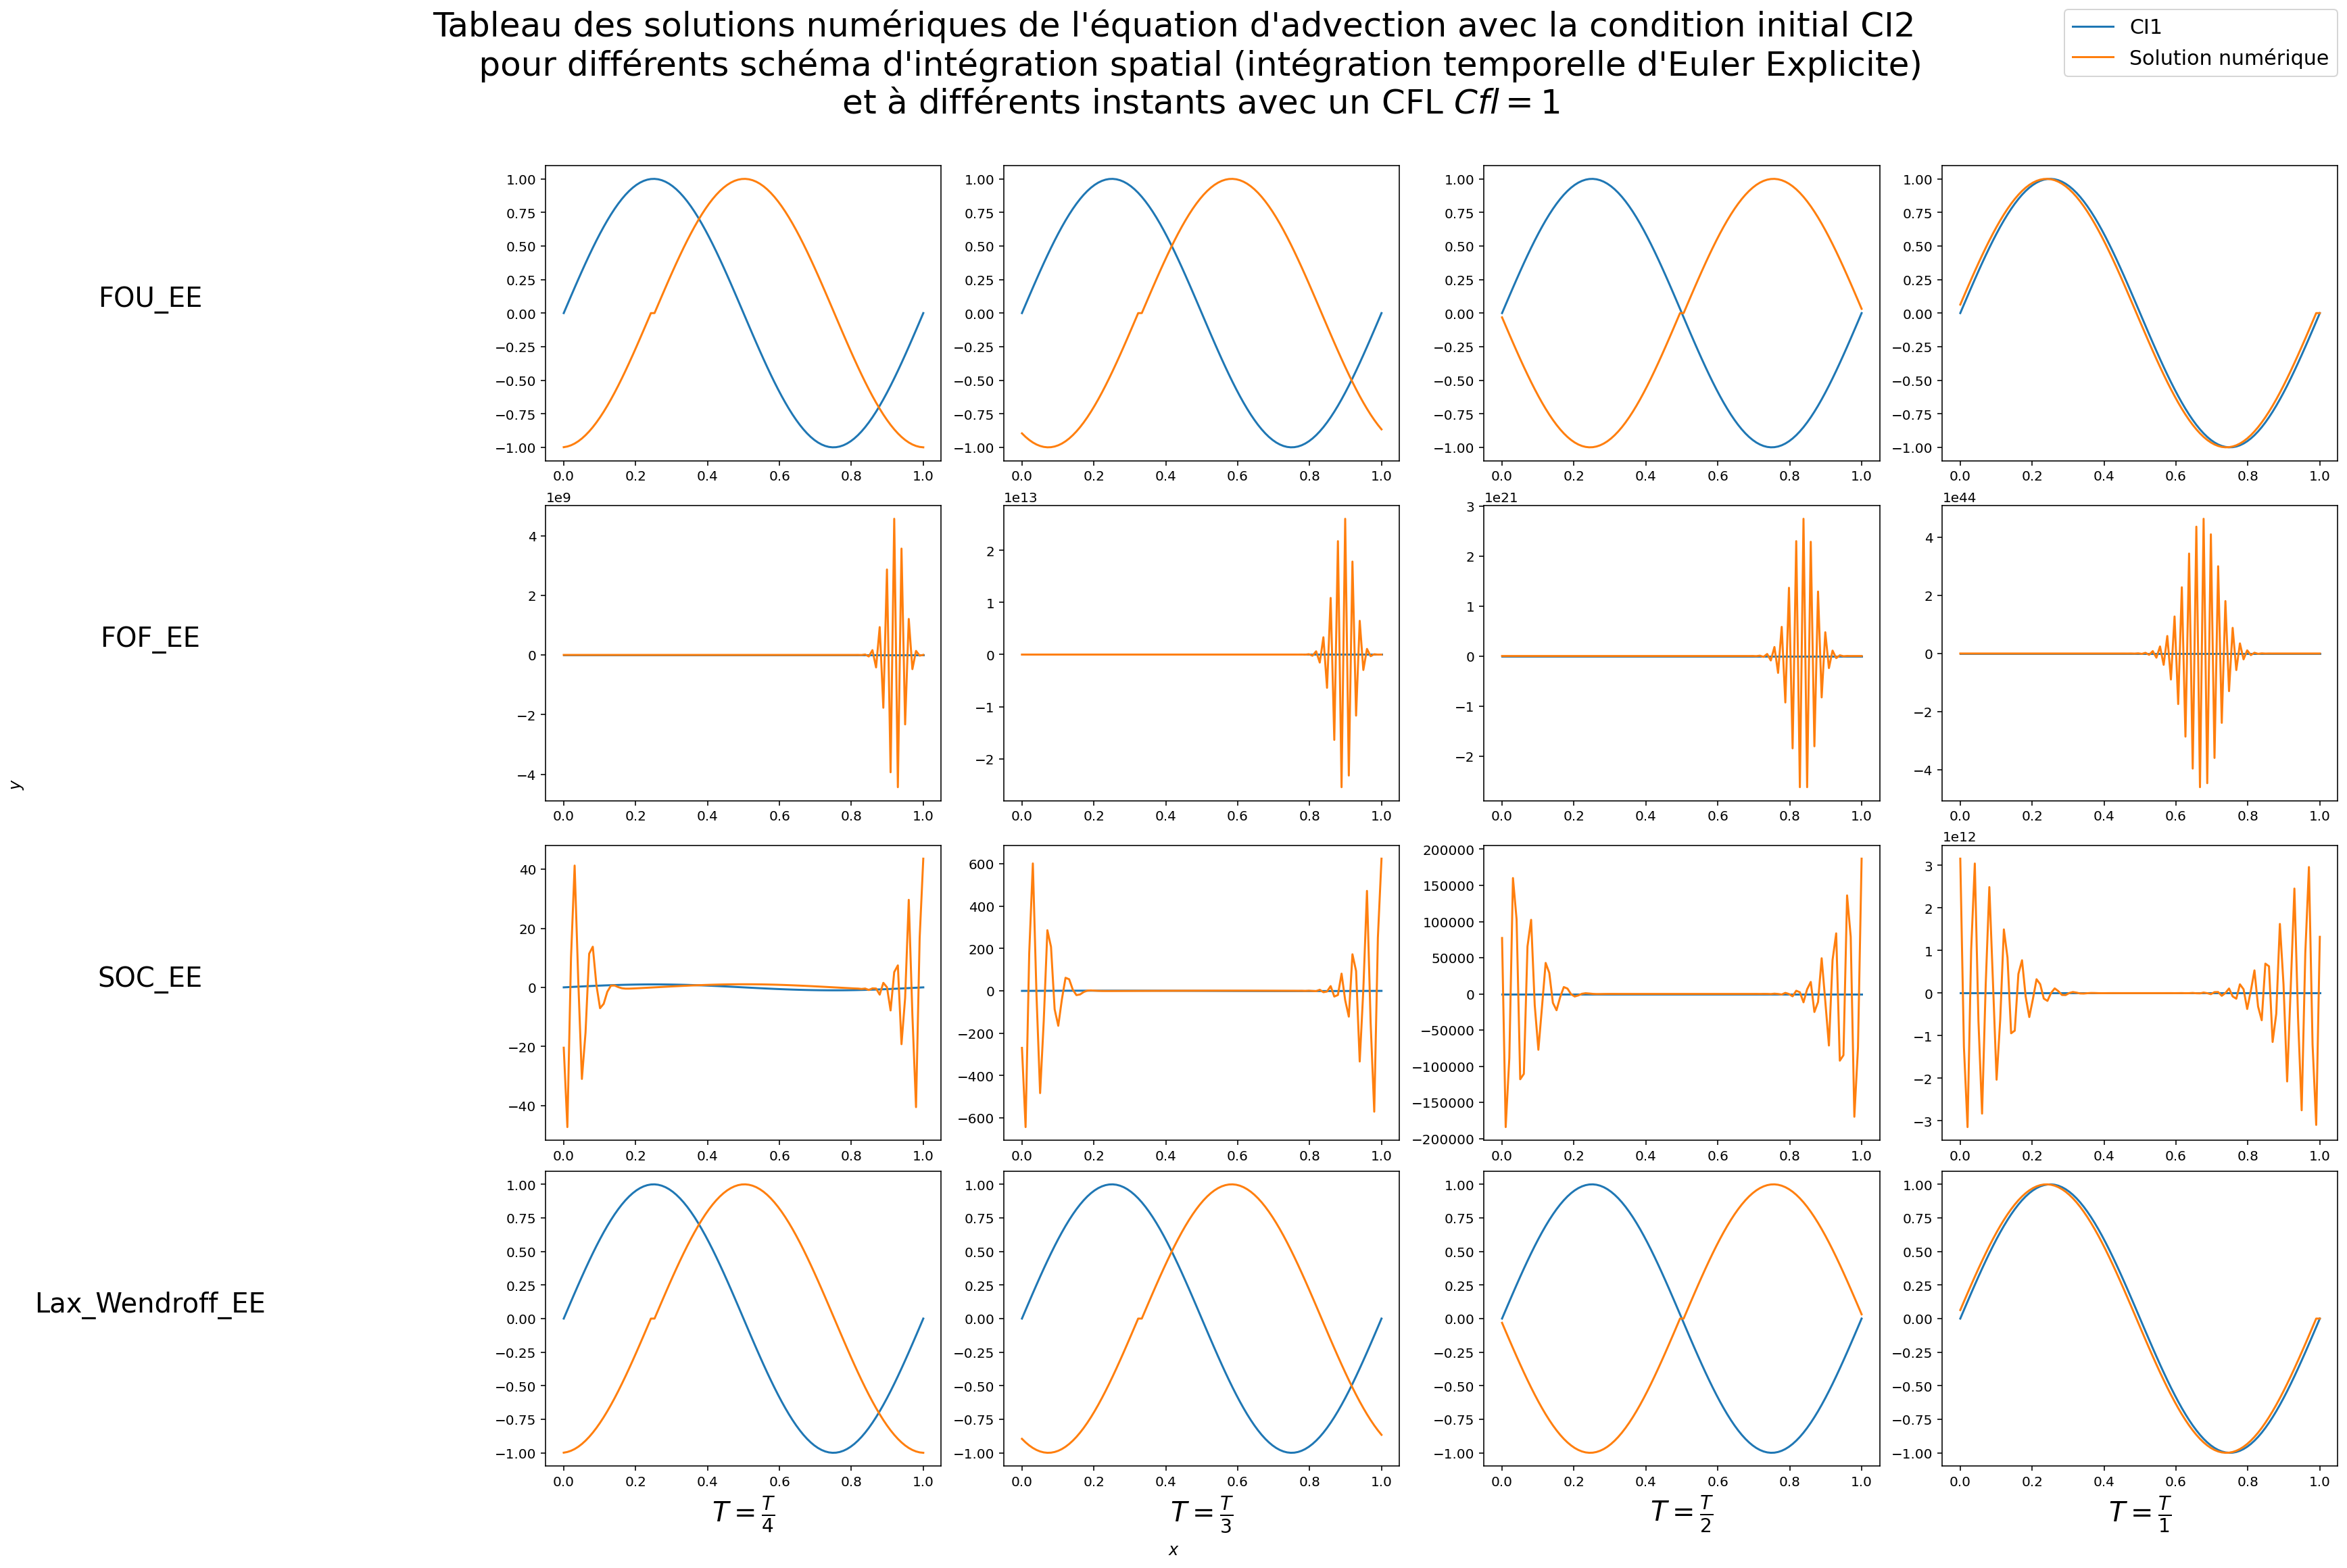

In [40]:
T_list = [4, 3, 2, 1]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(T_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et à différents instants avec un CFL $Cfl = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, P in enumerate(T_list):
        axs[-1, j].set_xlabel(f"$T = \\frac{{T}}{{{P}}}$", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI1', L=1,
                 m=100, C=1.0, a=1.0, beta=1, x0=0.5, P=P, ax=axs[i, j])

fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


- Refaire l’étude sur l’influence du nombre $\mathcal{C}$ avec la condition initiale CI2.


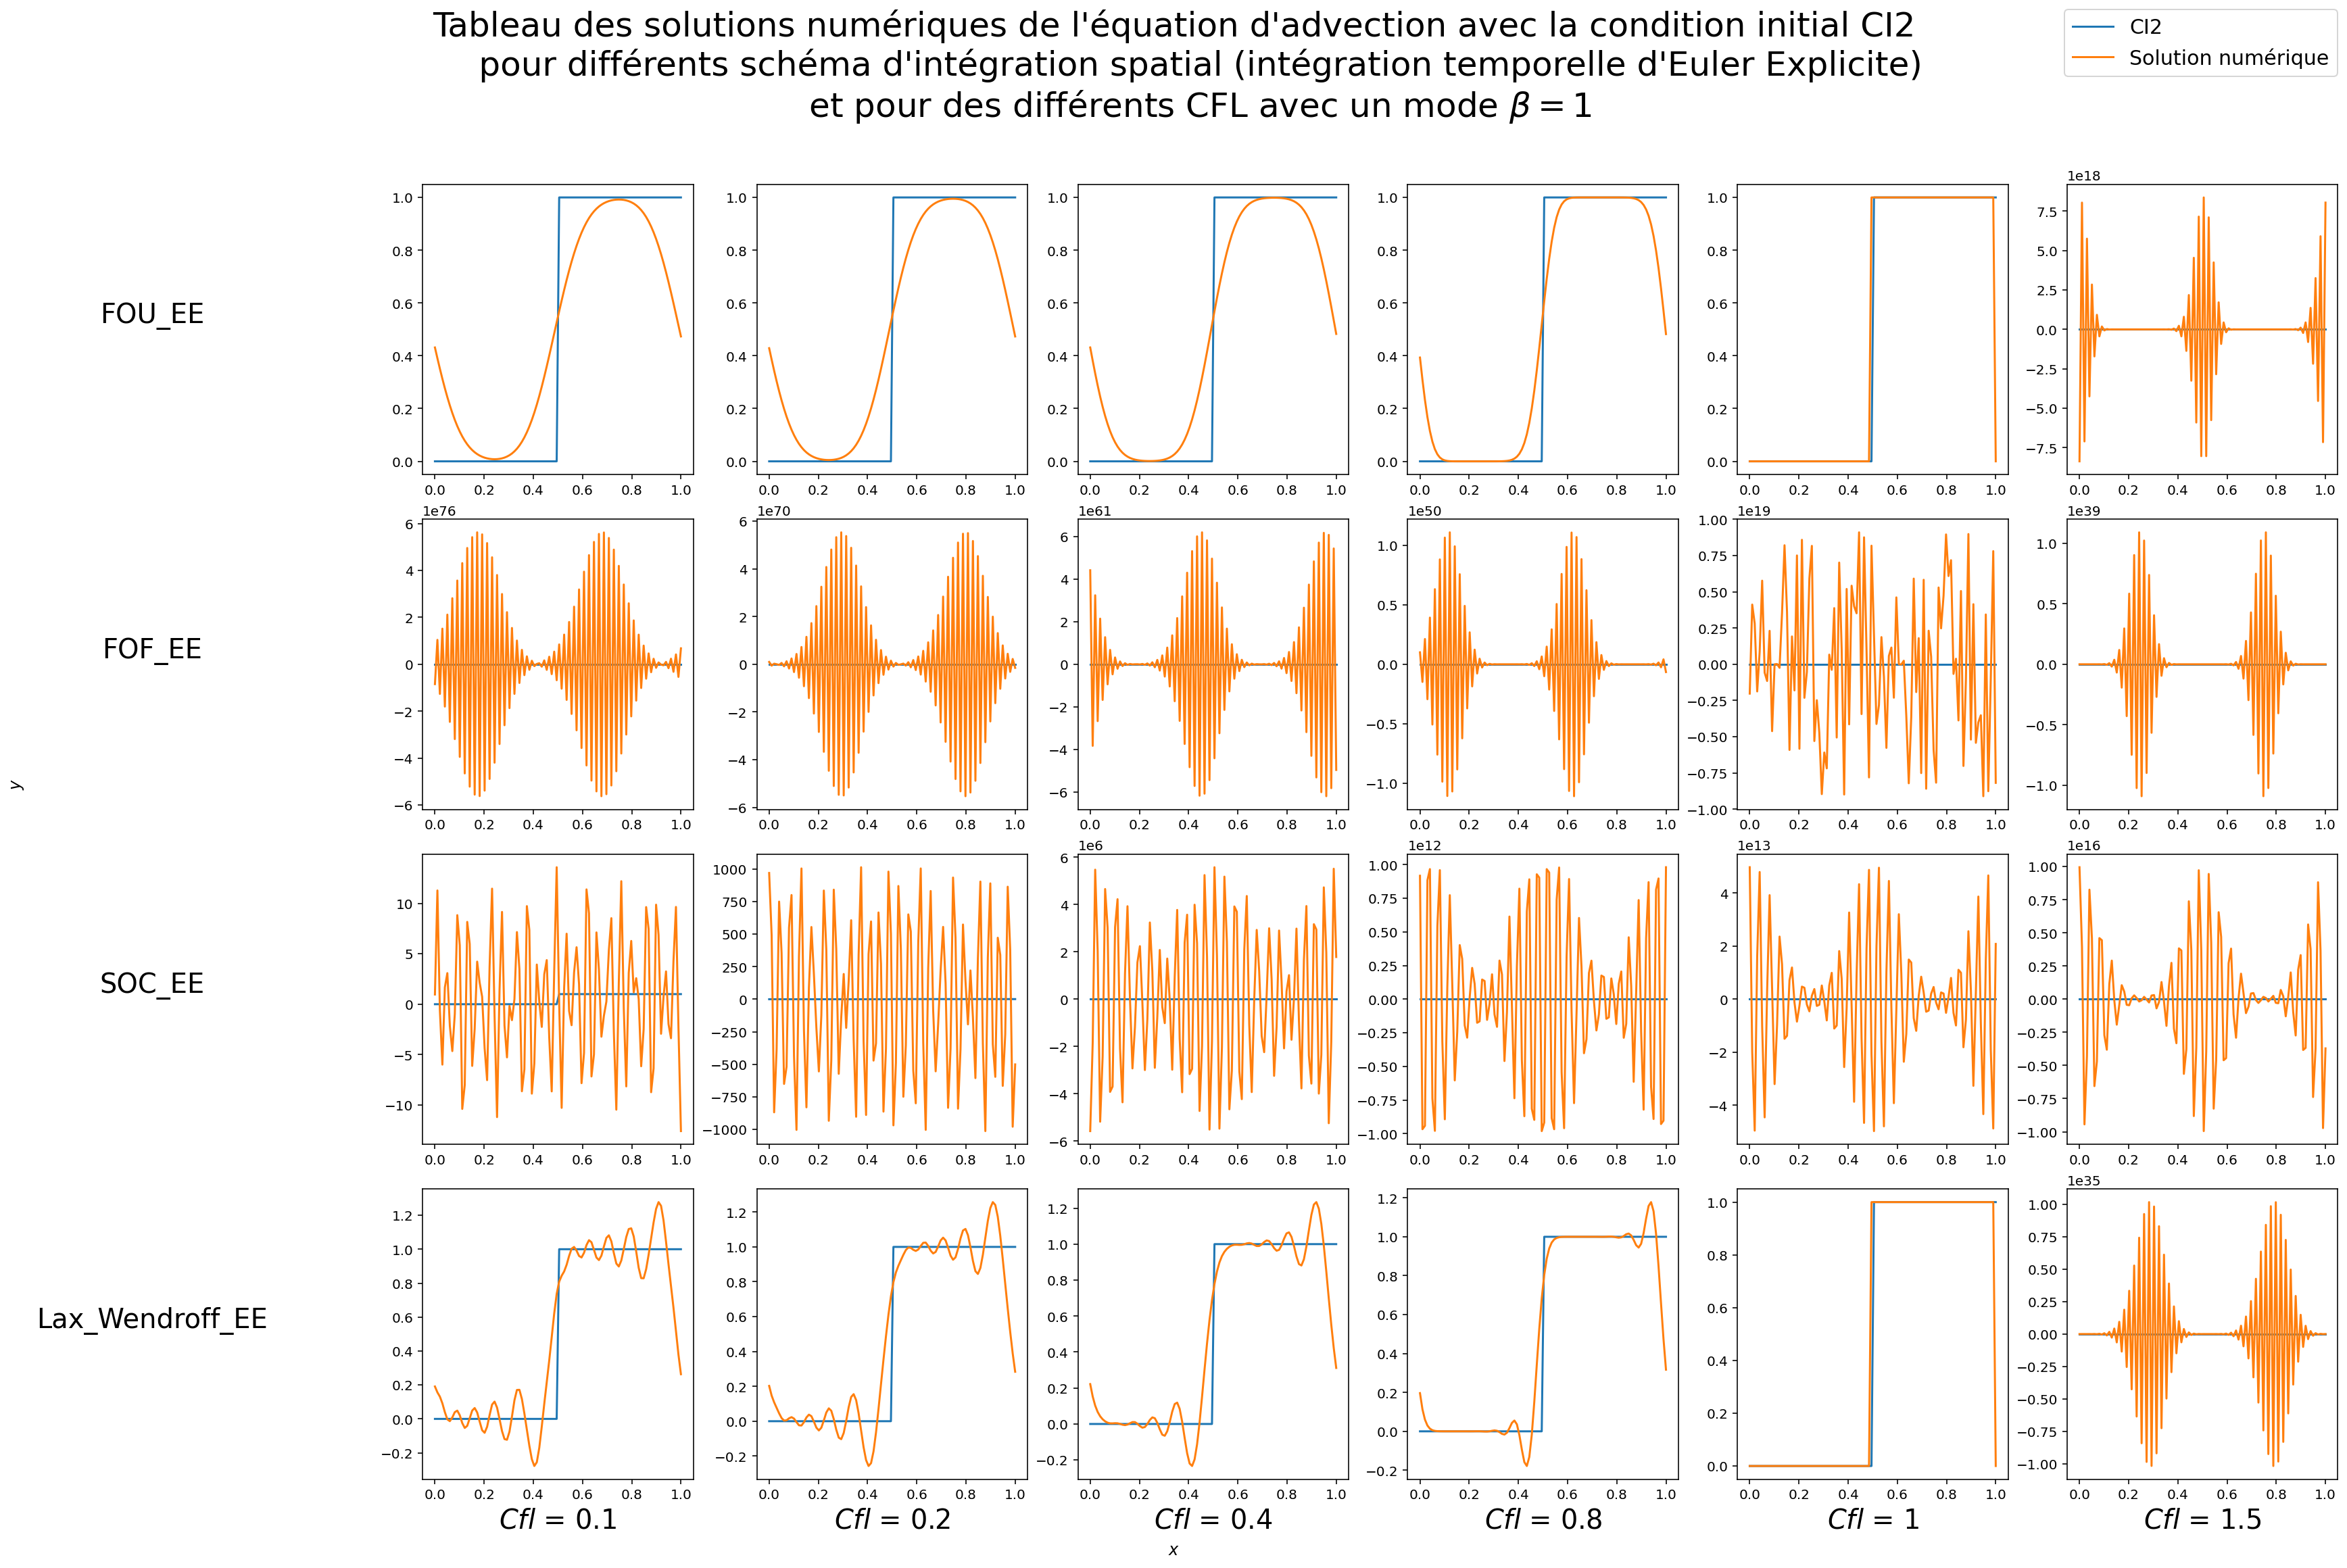

In [41]:
cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI2', L=1,
                 m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI2", f"Solution numérique"], fontsize=15)
plt.show()


- Toujours avec CI2 et $\mathcal{C} = 0.1$, étudiez l’influence de la discrétisation spatiale sur le résultat en prenant successivement un nombre de points $m$ égal à $4$, $10$, $20$, $50$, $100$ et $200$.

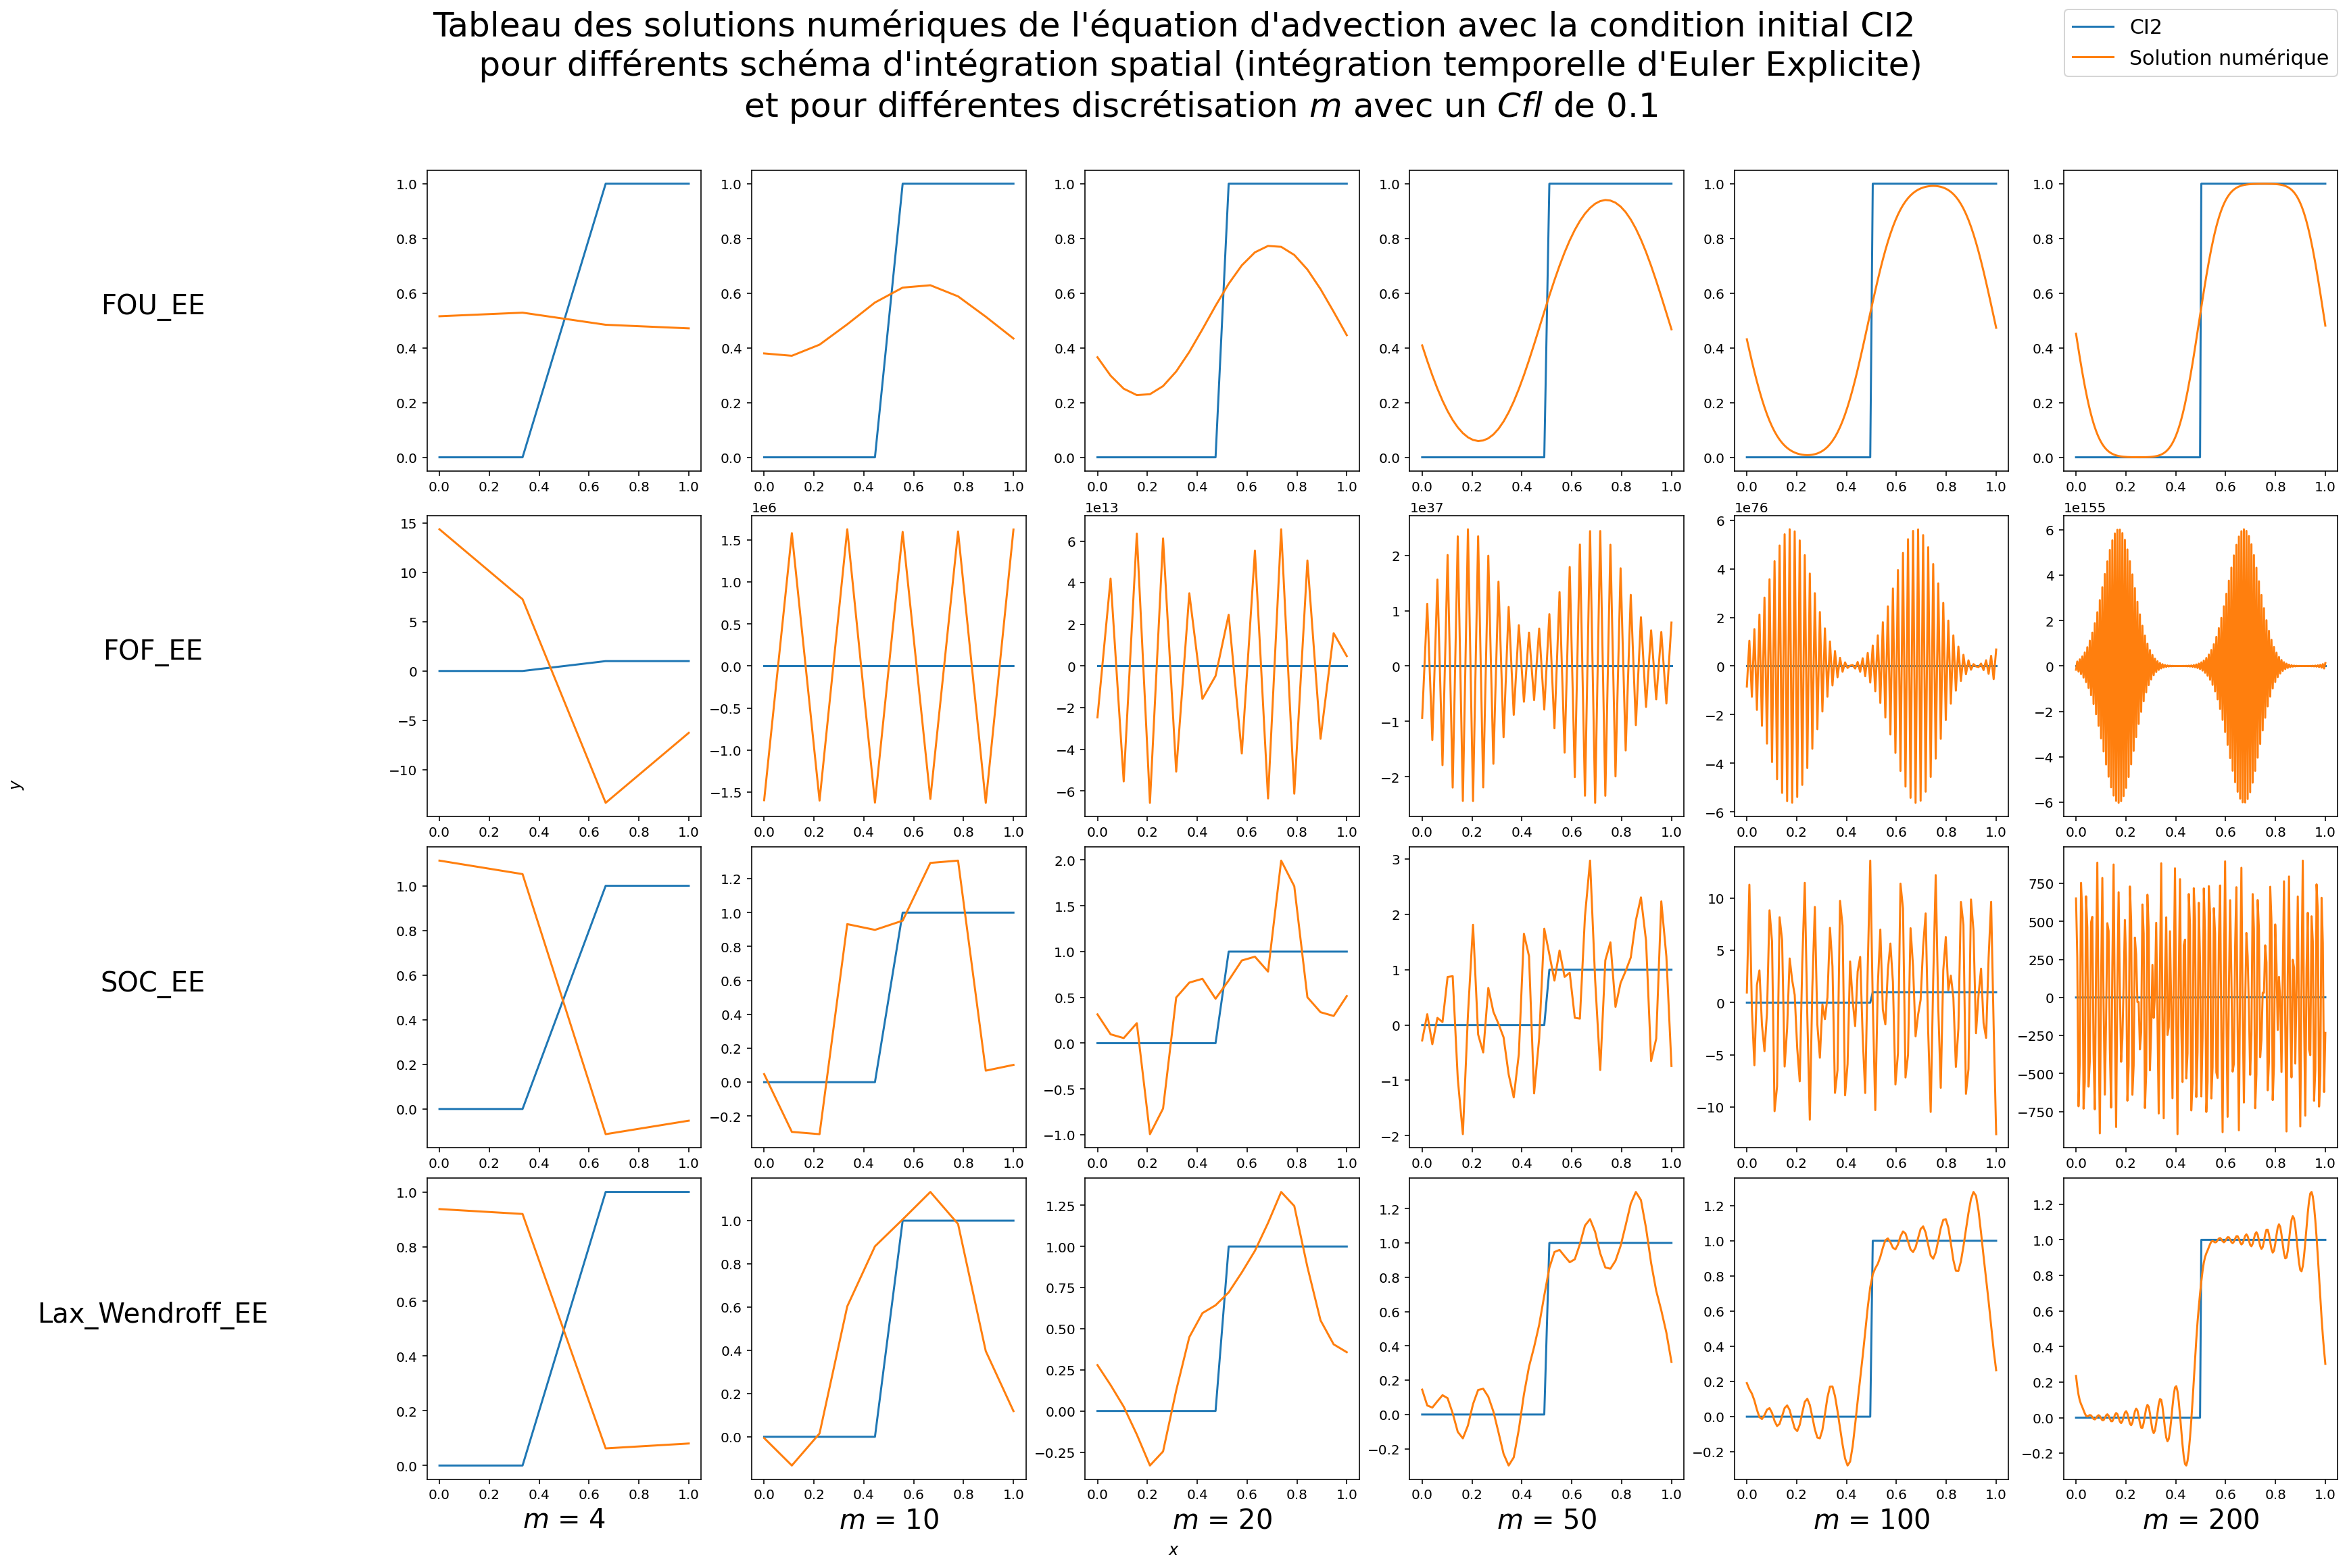

In [42]:
m_list = [4, 10, 20, 50, 100, 200]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(m_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différentes discrétisation $m$ avec un $Cfl$ de $0.1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")

for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, m in enumerate(m_list):
        axs[-1, j].set_xlabel(f"$m$ = {m}", rotation=0,
                              size=20)
        plot_sol(schema=schema, function_name='CI2', L=1,
                 m=m, C=0.1, a=1.0, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI2", f"Solution numérique"], fontsize=15)
plt.show()


- Que se passe-t-il si l’on change le signe de a ?

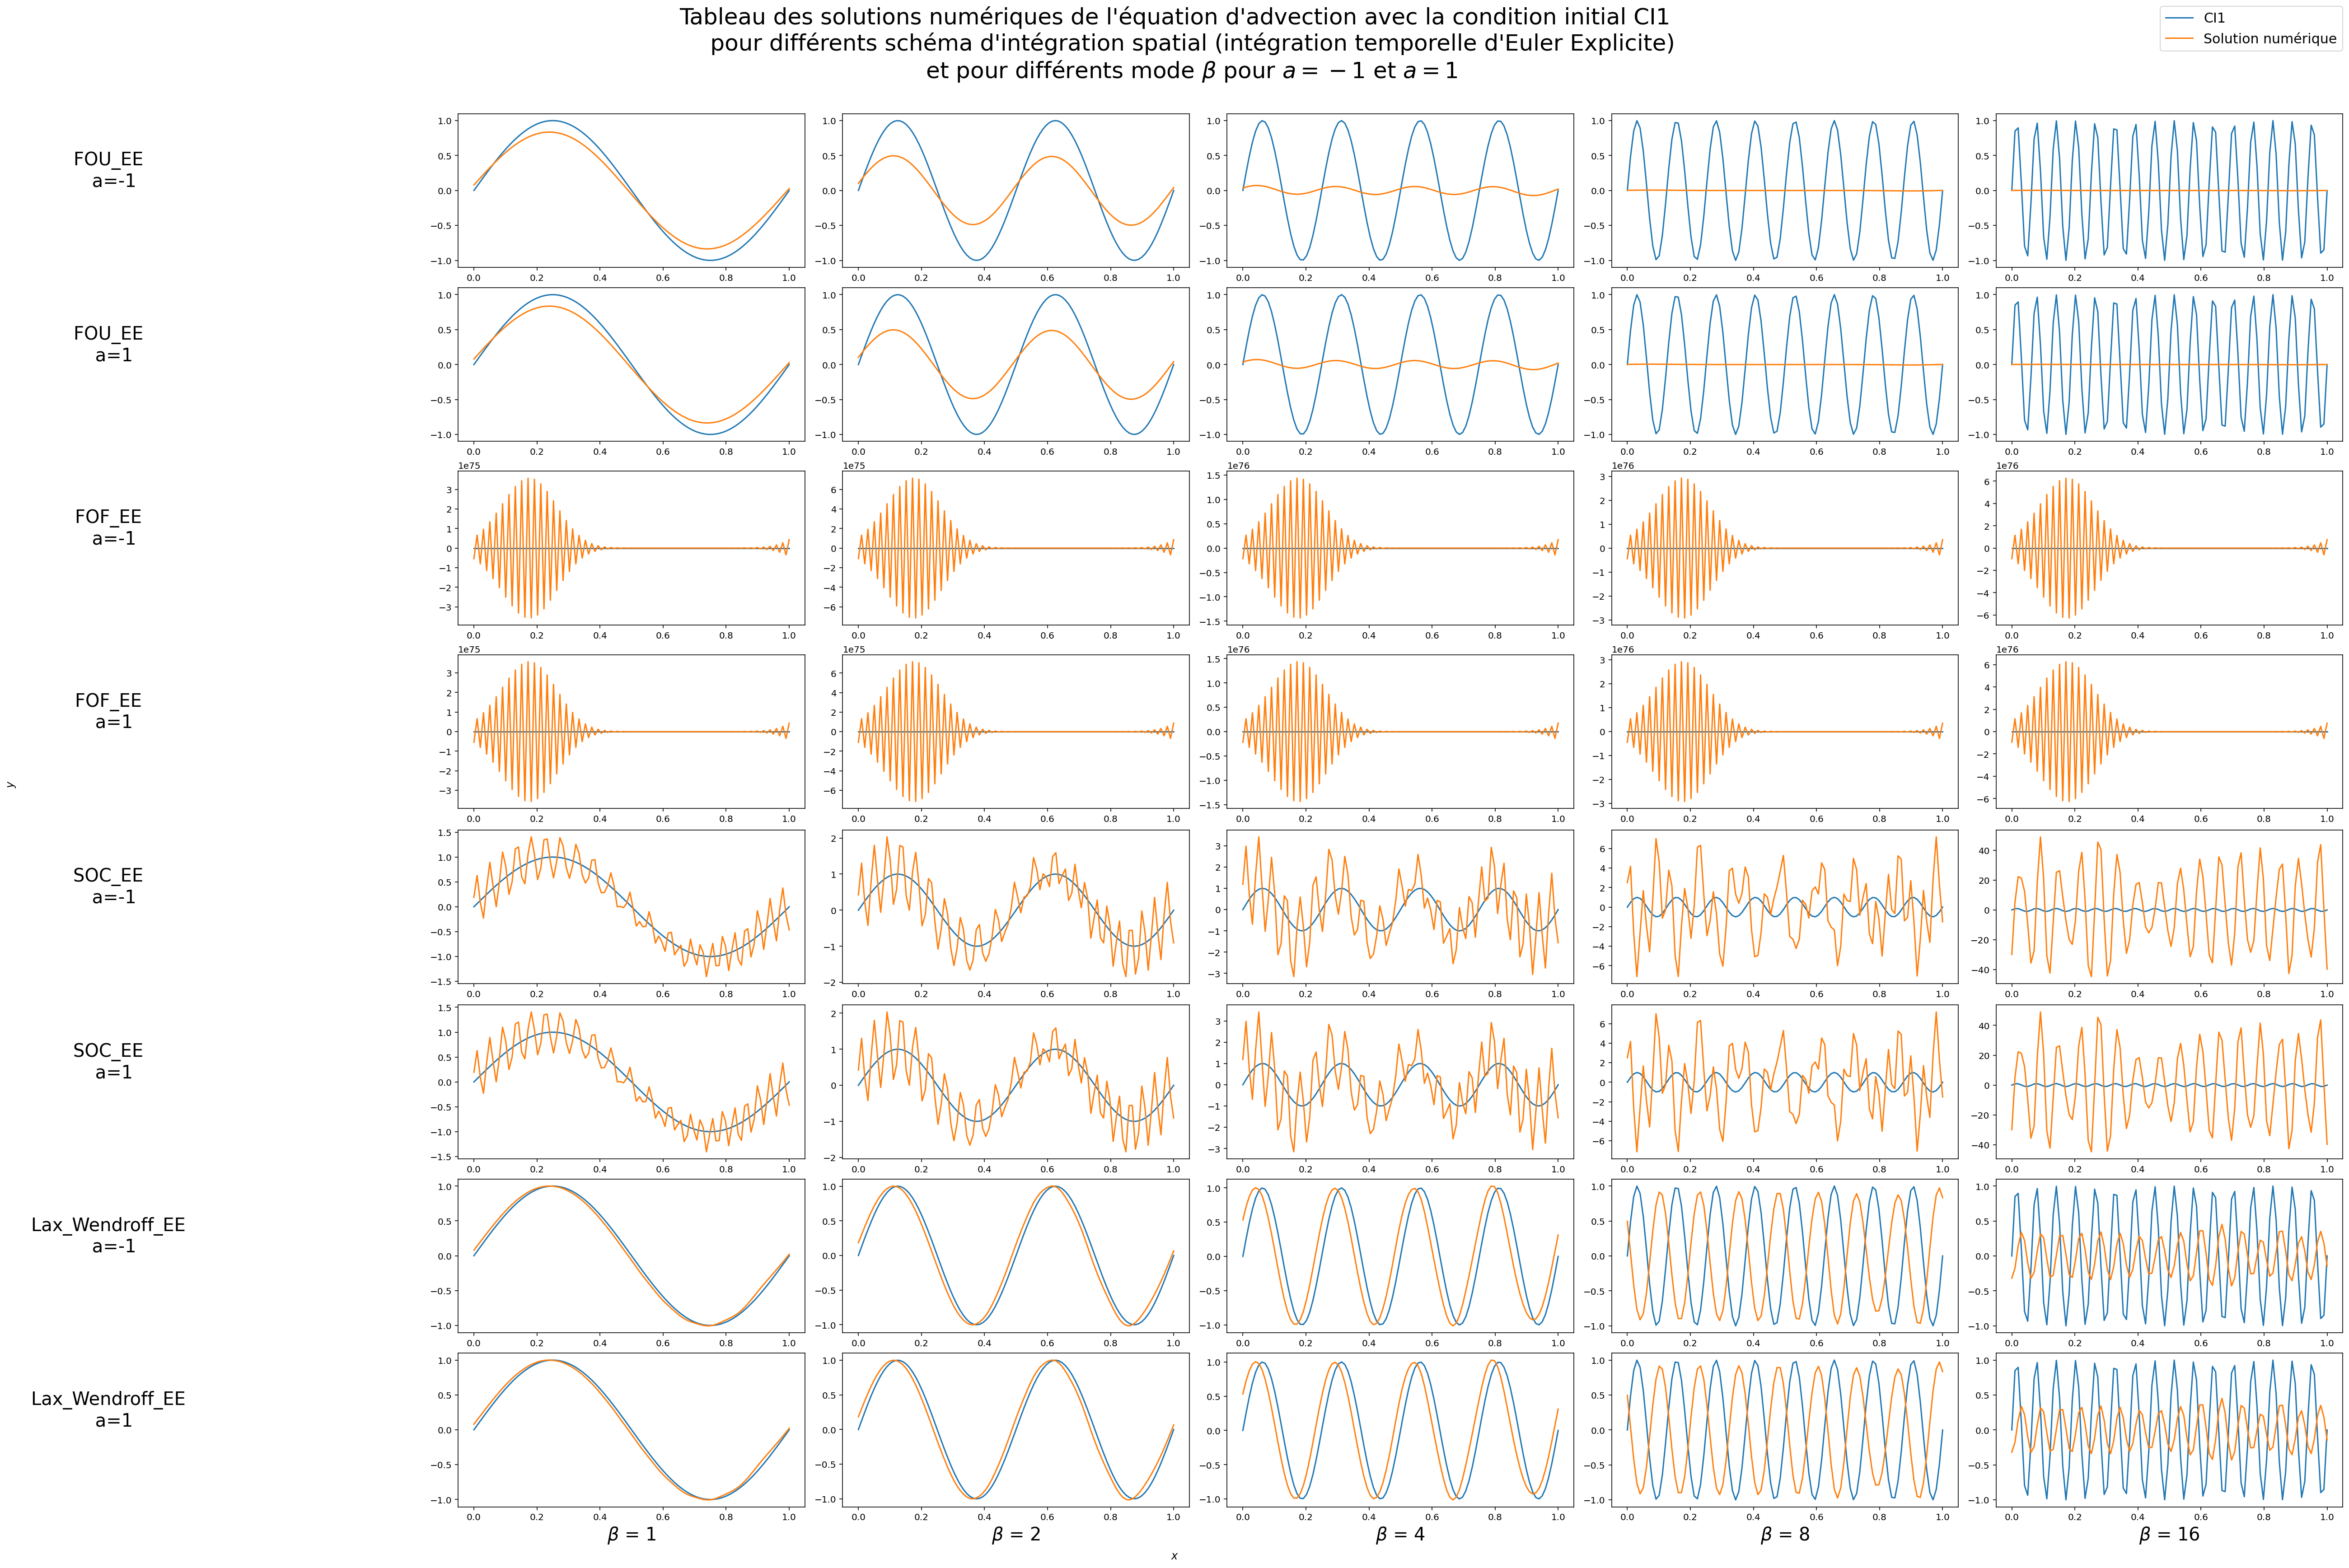

In [43]:
a_list = [-1, +1]
beta_list = [1, 2, 4, 8, 16]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list)*len(a_list),
                        ncols=len(beta_list), figsize=(36, 24))
fig.suptitle(
    f"Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différents mode $\\beta$ pour $a={a_list[0]}$ et $a={a_list[1]}$ \n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    for k, a in enumerate(a_list):
        axs[i*len(a_list)+k, 0].set_ylabel(f"{schema.__name__} \n a={a}", rotation=0,
                             size=20)
        axs[i*len(a_list)+k, 0].yaxis.set_label_coords(-1, 0.5)
        for j, beta in enumerate(beta_list):
            axs[-1, j].set_xlabel(f"$\\beta$ = {beta}", rotation=0,
                                size=20)
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=0.1, a=a, beta=beta, x0=0.5, P=1, ax=axs[i*len(a_list)+k, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


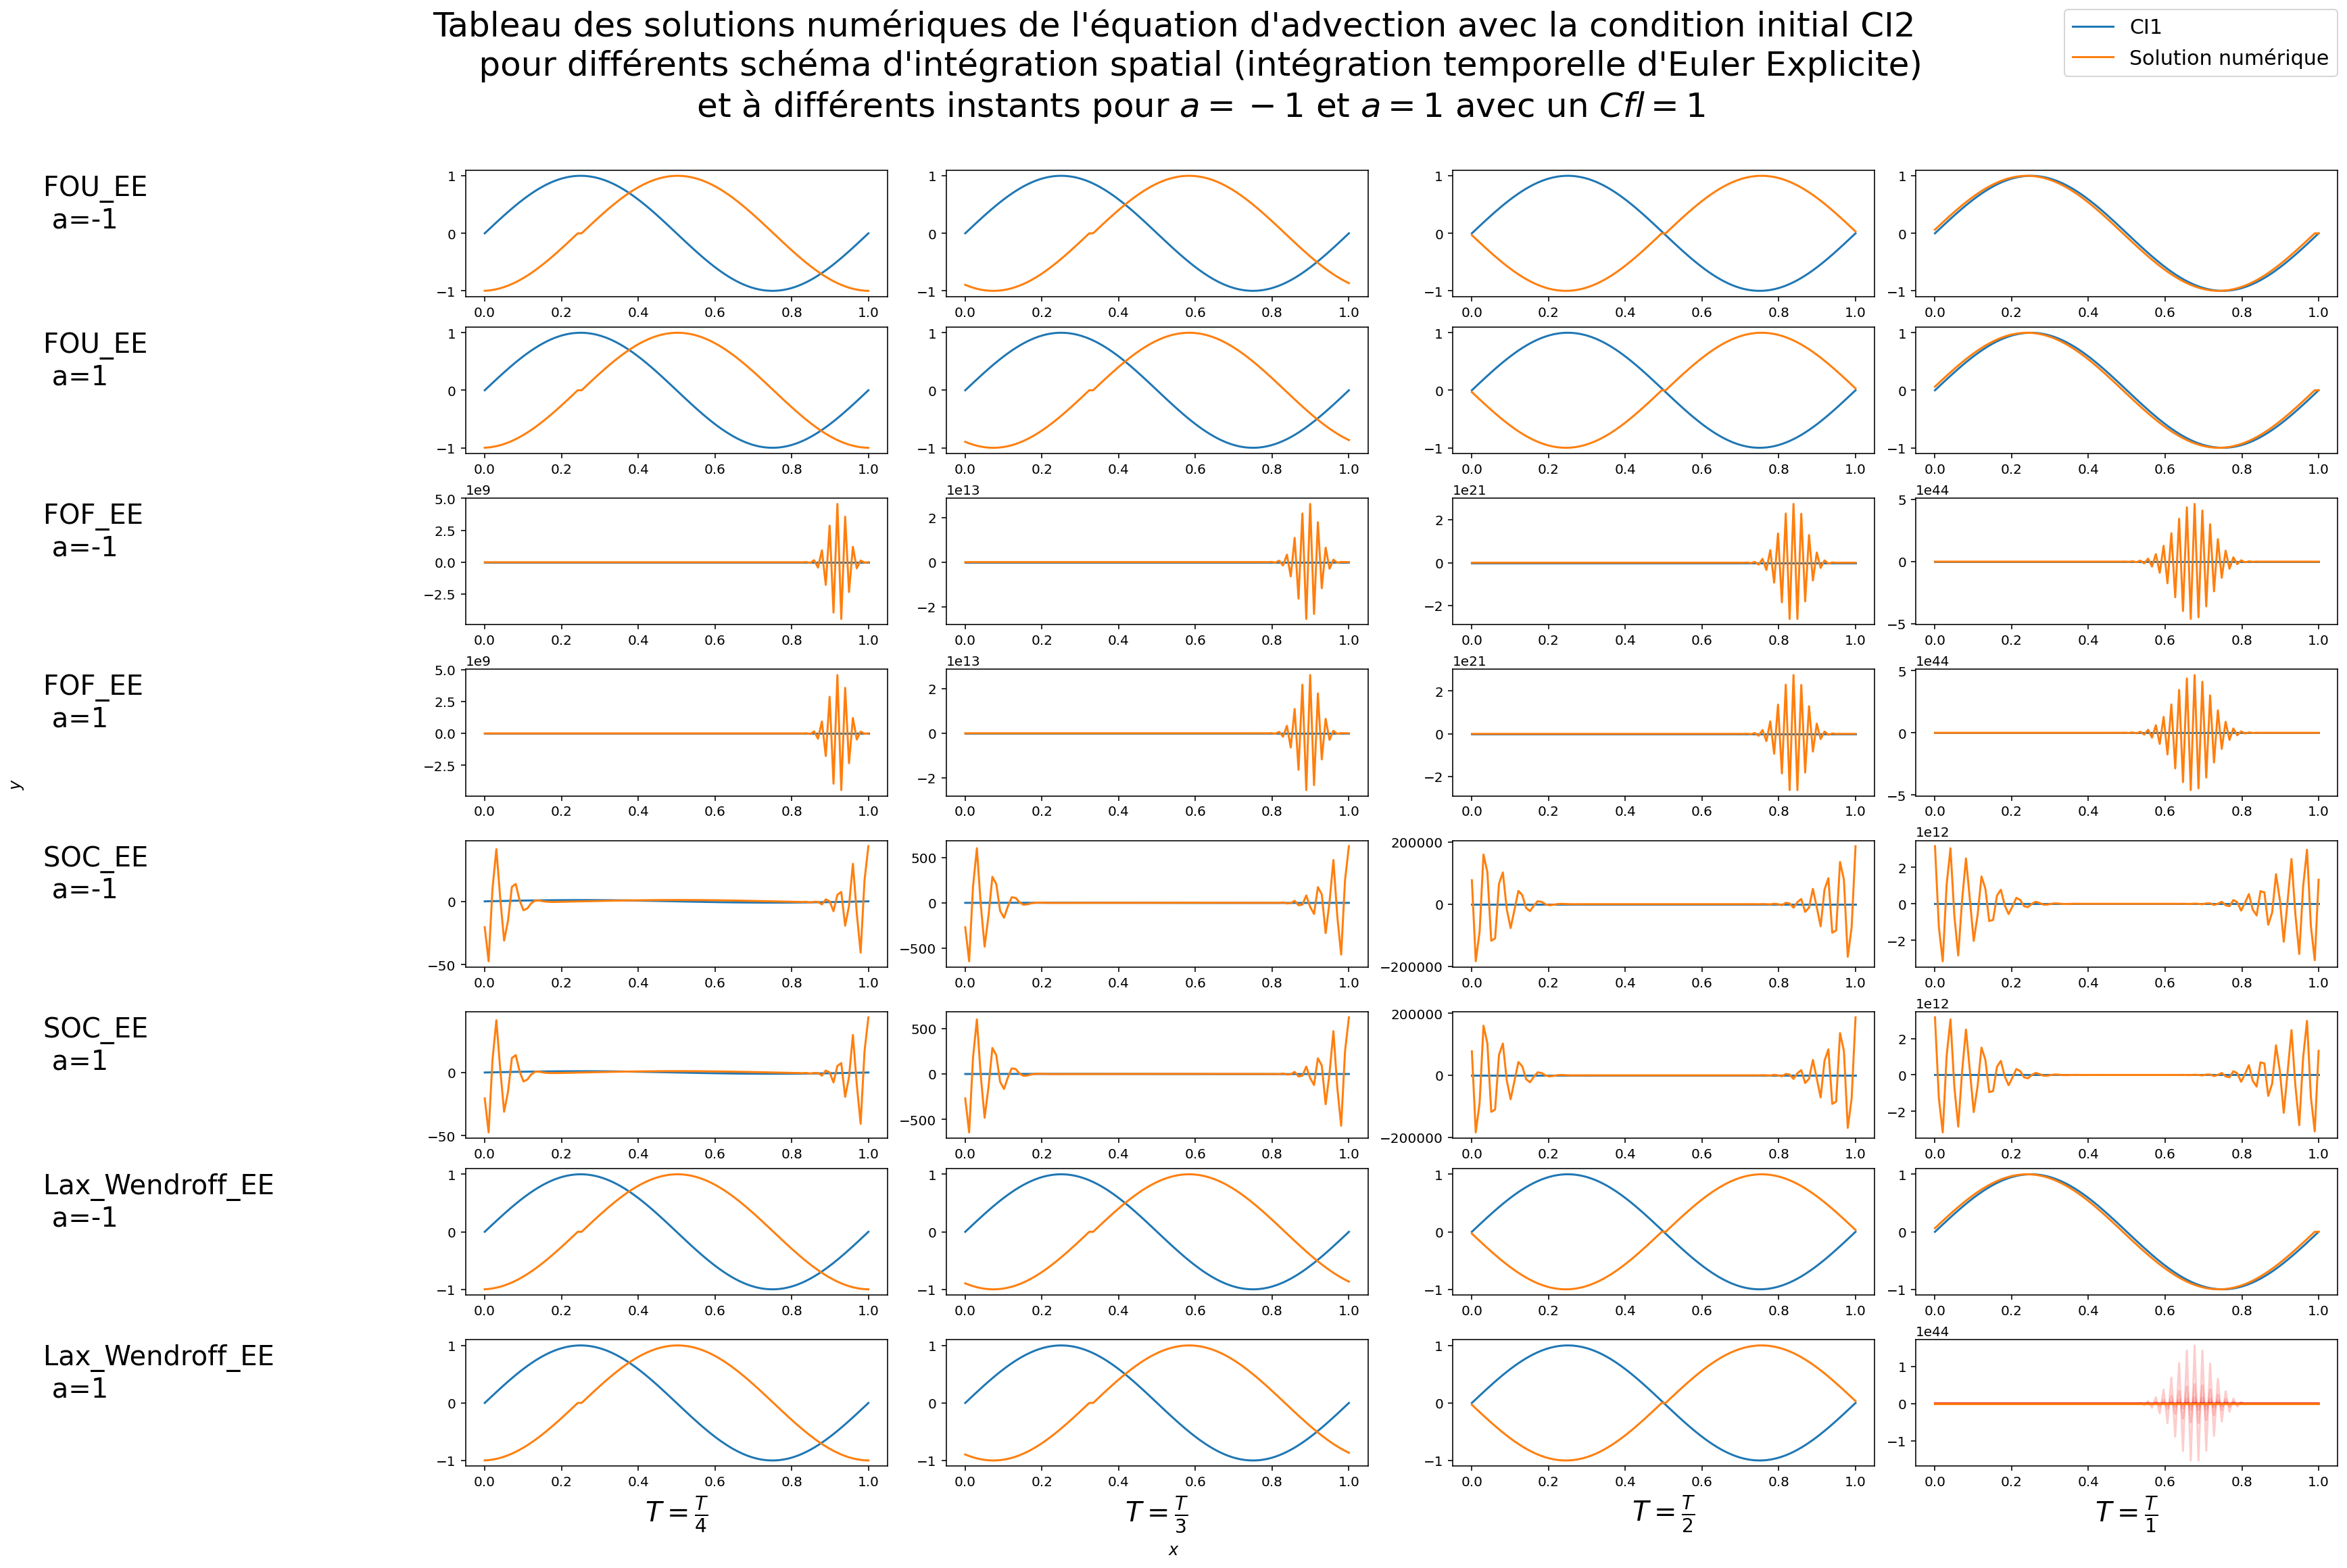

In [48]:
a_list = [-1, +1]
T_list = [4, 3, 2, 1]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE]

fig, axs = plt.subplots(nrows=len(schema_list)*len(a_list),
                        ncols=len(T_list), figsize=(24, 16))
fig.suptitle(
    f"Tableau des solutions numériques de l'équation d'advection avec la condition initial CI2\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et à différents instants pour $a={a_list[0]}$ et $a={a_list[1]}$ avec un $Cfl = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    for k, a in enumerate(a_list):
        axs[i*len(a_list)+k, 0].set_ylabel(f"{schema.__name__} \n a={a}", rotation=0, loc='bottom',
                                           size=20, 
                                           #labelpad=200
                                           )
        axs[i*len(a_list)+k, 0].yaxis.set_label_coords(-1, 0.5)
        for j, P in enumerate(T_list):
            axs[-1, j].set_xlabel(f"$T = \\frac{{T}}{{{P}}}$", rotation=0,
                                size=20)
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=1.0, a=1.0, beta=1, x0=0.5, P=P, ax=axs[i*len(a_list)+k, j])

fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()

## 3 - Bonus : Leapfrog

## Rappel du schéma **Leapforg** (Cf TD1):

$$\frac{u_{i}^{n+1}-u_{i}^{n-1}}{2 \Delta t}+a \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2 \Delta x}=0$$

$$u_{i} ^ {n+1} = u_{i} ^ {n-1} - \frac{\mathcal{C}}{2}\left(u_{i+1} ^ {n}-u_{i-1} ^ {n}\right)$$

In [45]:
def Leapfrog(ui, ui_moins, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui_moins, shift=-1) -
                          np.roll(ui_moins, shift=+1))
    return ui_plus


In [46]:
def plot_sol_leapfrog(schema=Leapfrog, schema2=Lax_Wendroff_EE, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1,
             trace=False, save=False, show=True, ax=plt):
    X = get_X(L, m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)

    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t)
    tMax = int(tMax/P)

    # t = t_0
    ut = u0
    ax.plot(X, ut)
    ut_plus = schema2(ut, C)

    # t = t_i
    for t in range(tMax):
        ut = schema(ut, ut_plus, C)
        if trace:
            plt.plot(X, ut, c=(t/tMax, 0., 0.), alpha=0.1)

    # t = t_max
    ut = schema(ut, C)
    ax.plot(X, ut)
    if ax == plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, {schema2.__name__}, L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__{schema2.__name__}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()

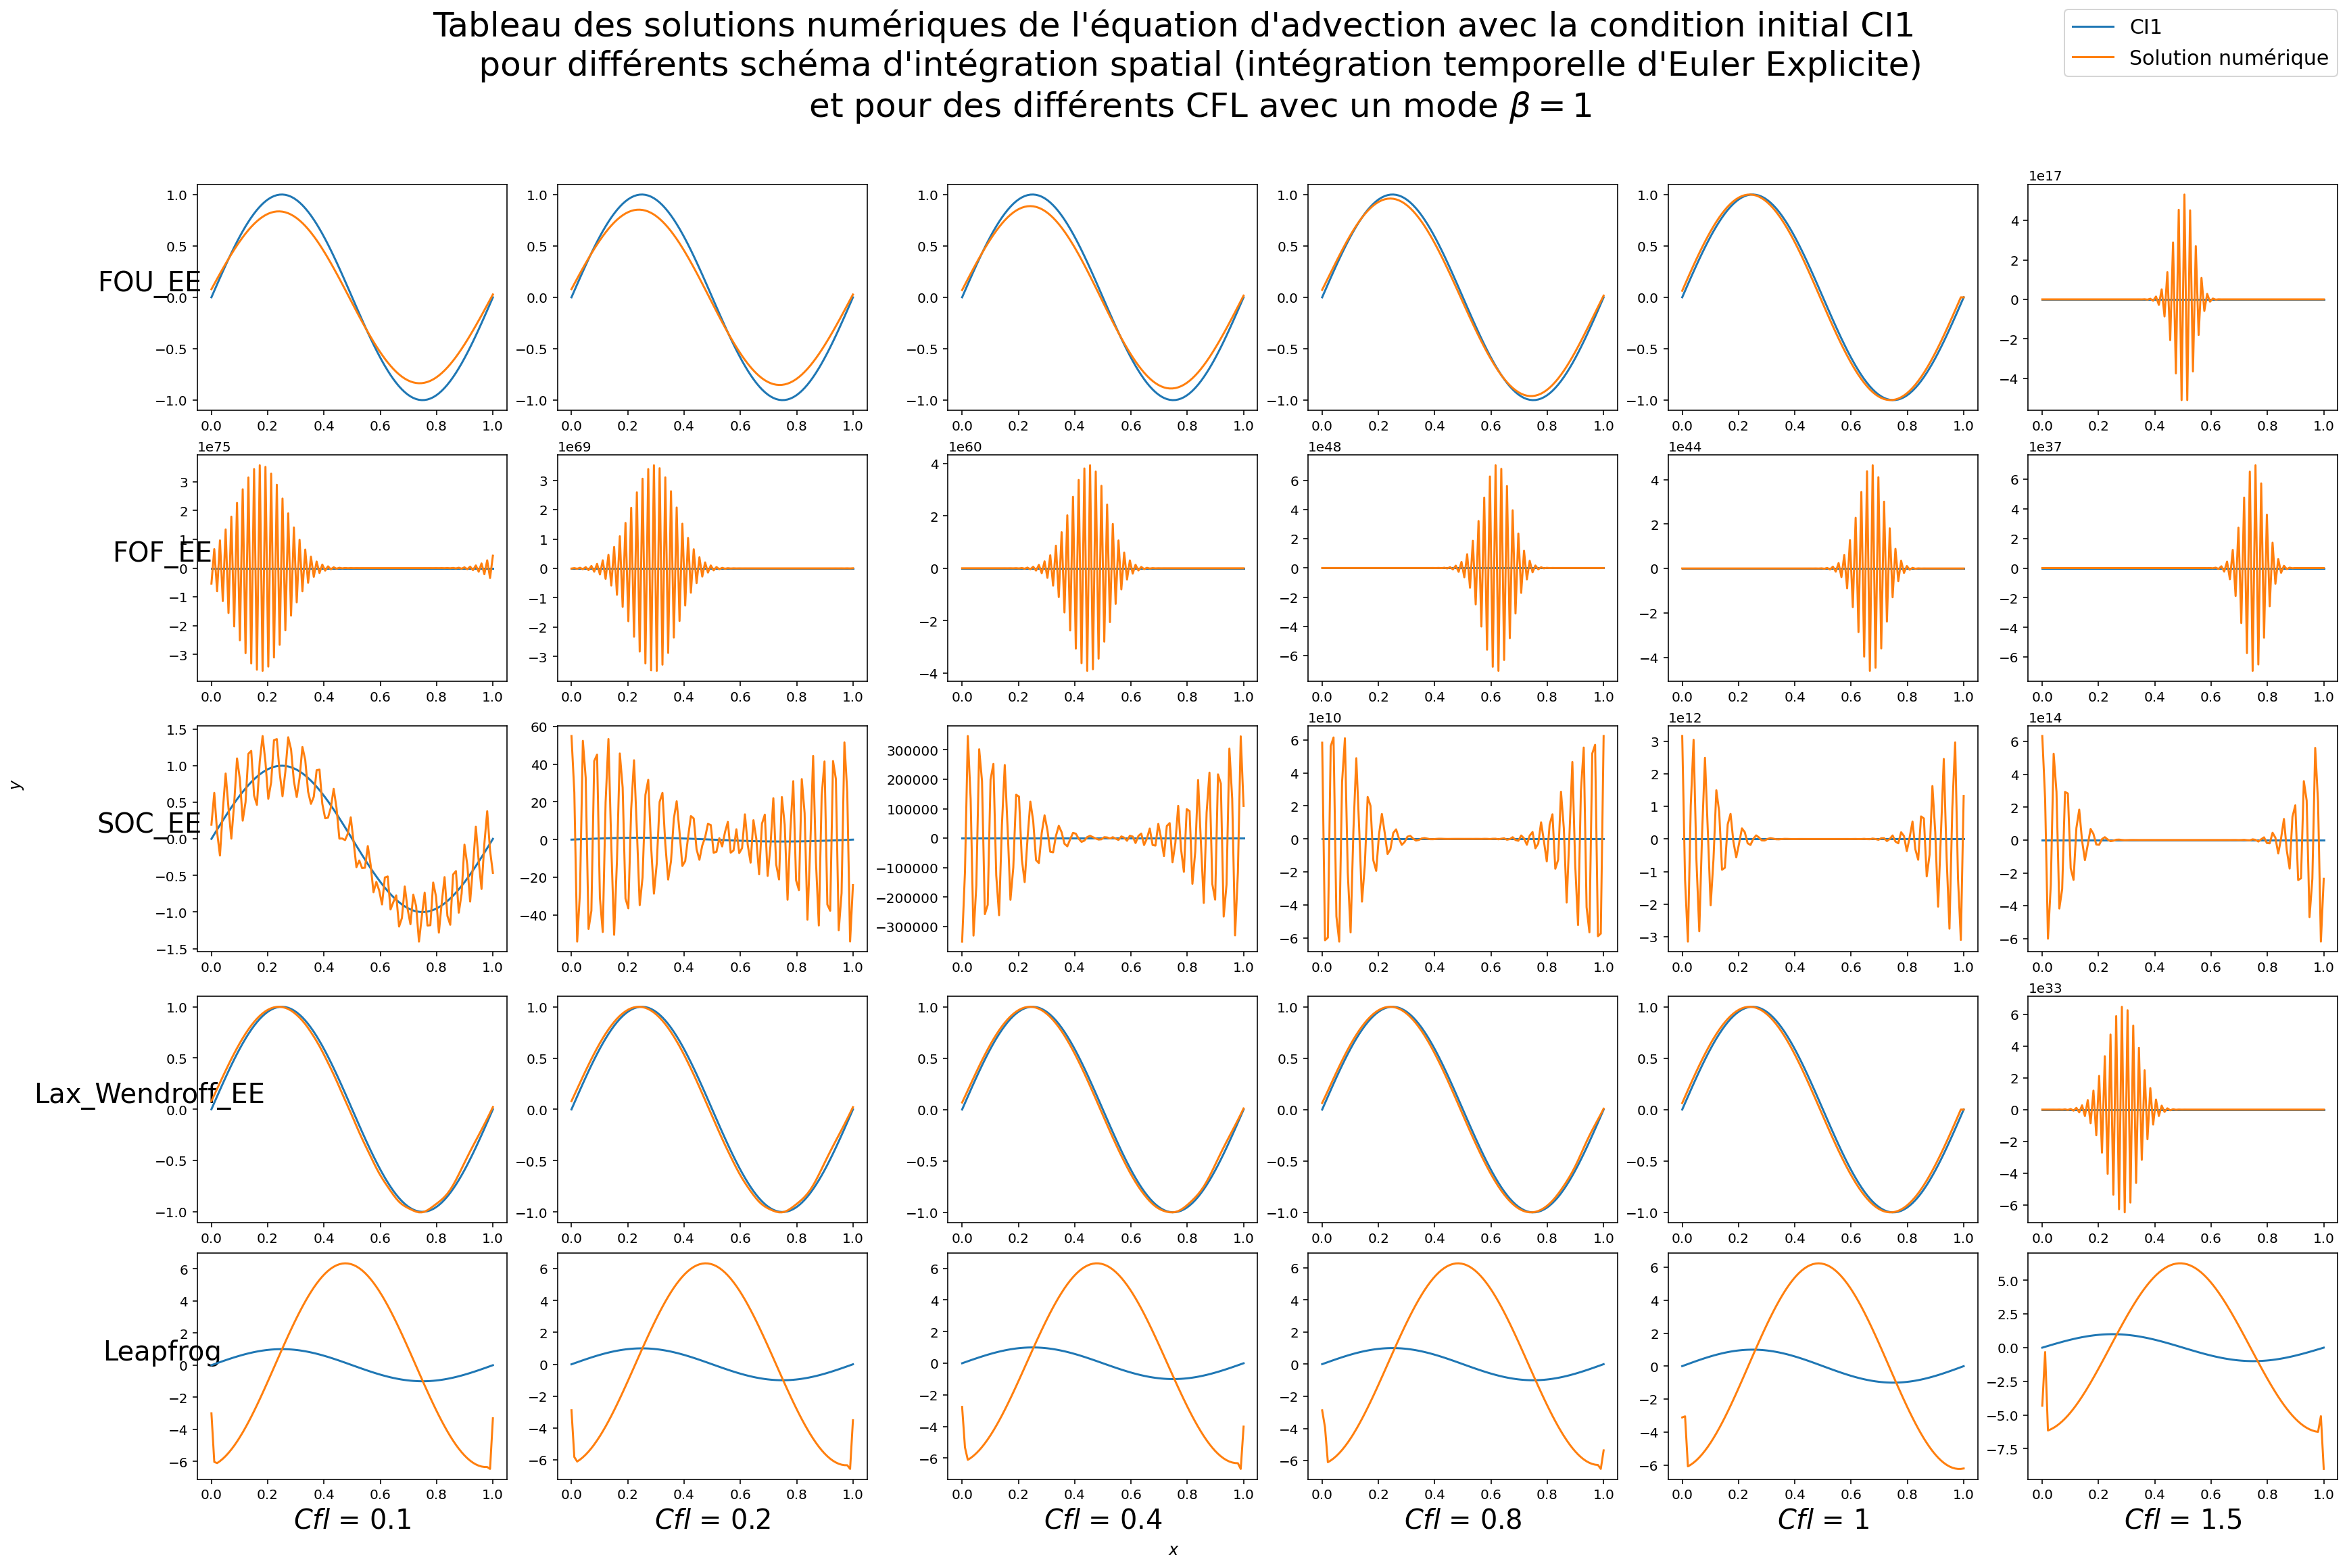

In [47]:
cfl_list = [0.1, 0.2, 0.4, 0.8, 1, 1.5]
schema_list = [FOU_EE, FOF_EE, SOC_EE, Lax_Wendroff_EE, Leapfrog]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(cfl_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour des différents CFL avec un mode $\\beta = 1$\n", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")
for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    for j, cfl in enumerate(cfl_list):
        axs[-1, j].set_xlabel(f"$Cfl$ = {cfl}", rotation=0,
                              size=20)
        if schema == Leapfrog:
            plot_sol_leapfrog(schema=schema, schema2=Lax_Wendroff_EE, function_name='CI1', L=1,
                    m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
        else:
            plot_sol(schema=schema, function_name='CI1', L=1,
                     m=100, C=cfl, a=1.0, beta=1, x0=0.5, P=1, ax=axs[i, j])
fig.legend([f"CI1", f"Solution numérique"], fontsize=15);
plt.show()